Load Data

In [ ]:
#Load the data
import pandas as pd
train = pd.read_csv("/kaggle/input/widsdatathon2024-challenge1/training.csv")
test = pd.read_csv("/kaggle/input/widsdatathon2024-challenge1/test.csv")
sample_submission = pd.read_csv("/kaggle/input/widsdatathon2024-challenge1/sample_submission.csv")


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/widsdatathon2024-challenge1/training.csv'

Data Preprocessing

In [ ]:
!pip install nltk
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# NLP pipeline for description preprocessing

import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

df = pd.read_csv('test.csv')
dataf=df.copy()

# mapping dictionary for specific replacements
correction_dict = {
    'Malig': 'Malignant',
    'neoplm': 'neoplasm',
    'unsp': 'unspecified',
    'ovrlp': 'overlap'
}

# Text Cleaning
def clean_text(text):
    # Spell correction for whole words only
    words = text.split()
    corrected_words = [correction_dict.get(word, word) for word in words]
    text = ' '.join(corrected_words)

    # Remove unnecessary characters, symbols, or special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert the text to lowercase
    text = text.lower()
    return text

dataf['cleaned_text'] = dataf['breast_cancer_diagnosis_desc'].apply(clean_text)

# Tokenization
def tokenize_text(text):
    return word_tokenize(text)

dataf['tokenized_text'] = dataf['cleaned_text'].apply(tokenize_text)

# Stopword Removal
stop_words = set(stopwords.words('english'))

def remove_stopwords(tokens):
    return [word for word in tokens if word not in stop_words]

dataf['filtered_tokens'] = dataf['tokenized_text'].apply(remove_stopwords)

# Lemmatization
lemmatizer = WordNetLemmatizer()

def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(word) for word in tokens]

dataf['lemmatized_tokens'] = dataf['filtered_tokens'].apply(lemmatize_tokens)
# Save the processed text in a new column
dataf['processed_text'] = dataf['lemmatized_tokens'].apply(lambda x: ' '.join(x))

# Define the words to remove
words_to_remove = ['malignant', 'neoplasm', 'site', 'breast', 'female']

# Create a new column with the specified words removed
dataf['imp_desc'] = dataf['processed_text'].replace('|'.join(words_to_remove), '', regex=True).replace('\s+', ' ', regex=True)

# Remove rows with empty strings in 'imp_desc'
dataf = dataf[dataf['imp_desc'].str.strip() != '']

# Function to remove repeated words in a block and maintain order
def remove_repeated_words(text):
    words = text.split()
    unique_words = []

    for word in words:
        if word not in unique_words:
            unique_words.append(word)

    return ' '.join(unique_words)

# Apply the function to the 'imp_desc' column
dataf['affected_site'] = dataf['imp_desc'].apply(remove_repeated_words)
df['processed_text'] = dataf['processed_text']
df['affected_site'] = dataf['affected_site']
# DataFrame with the new column
print(dataf[['breast_cancer_diagnosis_desc', 'affected_site']])


                           breast_cancer_diagnosis_desc  \
0     Malig neoplasm of upper-outer quadrant of left...   
1     Malignant neoplasm of unspecified site of left...   
2     Malignant neoplasm of unsp site of right femal...   
3     Malignant neoplasm of unspecified site of left...   
4     Malig neoplasm of upper-outer quadrant of left...   
...                                                 ...   
5787  Malig neoplm of upper-outer quadrant of right ...   
5788  Malignant neoplasm of unspecified site of left...   
5789  Malig neoplm of upper-outer quadrant of right ...   
5790  Malignant neoplasm of breast (female), unspeci...   
5791  Malignant neoplasm of central portion of right...   

                  affected_site  
0      upperouter quadrant left  
1              unspecified left  
2             unspecified right  
3              unspecified left  
4      upperouter quadrant left  
...                         ...  
5787  upperouter quadrant right  
5788           unsp

In [ ]:
# encoding affected site

# Fill missing values
df['affected_site'].fillna('unspecified', inplace=True)

# column for frequency encoding
dfc = df['affected_site']

frequency_encoding = dfc.value_counts(normalize=True).to_dict()

df_encoded = dfc.map(frequency_encoding)

df['affected_site'] = df_encoded

print(df)

      patient_id patient_race          payer_type patient_state  patient_zip3  \
0         573710        White            MEDICAID            IN           467   
1         593679          NaN          COMMERCIAL            FL           337   
2         184532     Hispanic            MEDICAID            CA           917   
3         447383     Hispanic  MEDICARE ADVANTAGE            CA           917   
4         687972        Black                 NaN            CA           900   
...          ...          ...                 ...           ...           ...   
5787      977076        White                 NaN            KY           404   
5788      922960        White                 NaN            IA           507   
5789      759690          NaN  MEDICARE ADVANTAGE            WA           980   
5790      911717          NaN          COMMERCIAL            OK           740   
5791      327597     Hispanic  MEDICARE ADVANTAGE            NY           114   

      patient_age patient_g

In [ ]:
# Patient_race null value filling

import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# Feature Selection
numerical_features = [
    'race_white', 'race_black', 'race_asian', 'race_native',
    'race_pacific', 'race_other', 'race_multiple', 'hispanic', 'patient_zip3'
]

categorical_feature = 'patient_race'


#DataFrame with rows containing null 'patient_race'
df_predict = df[df[categorical_feature].isnull()]

# Droping rows where the target variable has null values
training_data = df.dropna(subset=[categorical_feature] + numerical_features)

if not df_predict.empty:
    X = training_data[numerical_features]
    y = training_data[categorical_feature]

    model = RandomForestClassifier(random_state=42)

    model.fit(X, y)

    # Code to find accuracy
    # X_train, X_test, y_train, y_test = train_test_split(training_data[numerical_features], training_data[categorical_feature], test_size=0.2, shuffle=True)
    # model = RandomForestClassifier(random_state=42)
    # model.fit(X_train, y_train)
    # y_pred = model.predict(X_test)
    # accuracy = accuracy_score(y_test, y_pred)
    # print(f"Accuracy: {accuracy}")


# Prediction
    print("Before Prediction:")
    print("Total nulls: ", df['patient_race'].isnull().sum())
    print("count")
    print(df['patient_race'].value_counts())

    # 'patient_race_filled' has the predicted values
    df['patient_race_filled'] = df['patient_race']

    # Replacing null values in 'patient_race_filled' with the predicted values
    df.loc[df_predict.index, 'patient_race_filled'] = model.predict(df_predict[numerical_features])

    print("\nAfter Prediction:")
    print("Total nulls: ", df['patient_race_filled'].isnull().sum())
    print("count")
    print(df['patient_race_filled'].value_counts())



Before Prediction:
Total nulls:  2901
count
White       1606
Black        510
Hispanic     347
Other        273
Asian        155
Name: patient_race, dtype: int64

After Prediction:
Total nulls:  0
count
White       3795
Black        835
Hispanic     579
Other        389
Asian        194
Name: patient_race_filled, dtype: int64


In [ ]:
#patient race encoding
import pandas as pd

# column for one-hot encoding
dfc = df[['patient_race_filled']]

# Performing one-hot encoding
df_encoded = pd.get_dummies(dfc, columns=['patient_race_filled'], prefix=['race'])

# Merging data
data_encoded = pd.concat([df, df_encoded], axis=1)
df = data_encoded
print(data_encoded)


      patient_id patient_race          payer_type patient_state  patient_zip3  \
0         573710        White            MEDICAID            IN           467   
1         593679          NaN          COMMERCIAL            FL           337   
2         184532     Hispanic            MEDICAID            CA           917   
3         447383     Hispanic  MEDICARE ADVANTAGE            CA           917   
4         687972        Black                 NaN            CA           900   
...          ...          ...                 ...           ...           ...   
5787      977076        White                 NaN            KY           404   
5788      922960        White                 NaN            IA           507   
5789      759690          NaN  MEDICARE ADVANTAGE            WA           980   
5790      911717          NaN          COMMERCIAL            OK           740   
5791      327597     Hispanic  MEDICARE ADVANTAGE            NY           114   

      patient_age patient_g

In [ ]:
# payer type encoding
import pandas as pd

#column for one-hot encoding
dfc = df[['payer_type']]

# Performing one-hot encoding
df_encoded = pd.get_dummies(dfc, columns=['payer_type'], prefix=['payer'])

# Merging data
data_encoded = pd.concat([df, df_encoded], axis=1)
df = data_encoded
print(data_encoded)


      patient_id patient_race          payer_type patient_state  patient_zip3  \
0         573710        White            MEDICAID            IN           467   
1         593679          NaN          COMMERCIAL            FL           337   
2         184532     Hispanic            MEDICAID            CA           917   
3         447383     Hispanic  MEDICARE ADVANTAGE            CA           917   
4         687972        Black                 NaN            CA           900   
...          ...          ...                 ...           ...           ...   
5787      977076        White                 NaN            KY           404   
5788      922960        White                 NaN            IA           507   
5789      759690          NaN  MEDICARE ADVANTAGE            WA           980   
5790      911717          NaN          COMMERCIAL            OK           740   
5791      327597     Hispanic  MEDICARE ADVANTAGE            NY           114   

      patient_age patient_g

In [ ]:
# gender encoding

from sklearn.preprocessing import LabelEncoder
import pandas as pd


# column for one-hot encoding
dfc = df[['patient_gender']]

# Performing one-hot encoding
df_encoded = pd.get_dummies(dfc, columns=['patient_gender'], prefix=['patient'])

# Merging the data
data_encoded = pd.concat([df, df_encoded], axis=1)
df = data_encoded
print(data_encoded)


      patient_id patient_race          payer_type patient_state  patient_zip3  \
0         573710        White            MEDICAID            IN           467   
1         593679          NaN          COMMERCIAL            FL           337   
2         184532     Hispanic            MEDICAID            CA           917   
3         447383     Hispanic  MEDICARE ADVANTAGE            CA           917   
4         687972        Black                 NaN            CA           900   
...          ...          ...                 ...           ...           ...   
5787      977076        White                 NaN            KY           404   
5788      922960        White                 NaN            IA           507   
5789      759690          NaN  MEDICARE ADVANTAGE            WA           980   
5790      911717          NaN          COMMERCIAL            OK           740   
5791      327597     Hispanic  MEDICARE ADVANTAGE            NY           114   

      patient_age patient_g

In [ ]:
# encoding breast_cancer_diagnosis_code

import pandas as pd

# Convert 'breast_cancer_diagnosis_code' to string type
df['breast_cancer_diagnosis_code'] = df['breast_cancer_diagnosis_code'].astype(str)

# Remove 'c' and 'C' from 'breast_cancer_diagnosis_code' column
df['breast_cancer_diagnosis_code'] = df['breast_cancer_diagnosis_code'].str.replace('[cC]', '', regex=True)

# Filling missing values
df['breast_cancer_diagnosis_code'].fillna('0', inplace=True)

# column for frequency encoding
dfc = df['breast_cancer_diagnosis_code']

# Frequency encoding
frequency_encoding = dfc.value_counts(normalize=True).to_dict()
df_encoded = dfc.map(frequency_encoding)

df['breast_cancer_diagnosis_code_encoded'] = df_encoded
print(df)


      patient_id patient_race          payer_type patient_state  patient_zip3  \
0         573710        White            MEDICAID            IN           467   
1         593679          NaN          COMMERCIAL            FL           337   
2         184532     Hispanic            MEDICAID            CA           917   
3         447383     Hispanic  MEDICARE ADVANTAGE            CA           917   
4         687972        Black                 NaN            CA           900   
...          ...          ...                 ...           ...           ...   
5787      977076        White                 NaN            KY           404   
5788      922960        White                 NaN            IA           507   
5789      759690          NaN  MEDICARE ADVANTAGE            WA           980   
5790      911717          NaN          COMMERCIAL            OK           740   
5791      327597     Hispanic  MEDICARE ADVANTAGE            NY           114   

      patient_age patient_g

In [ ]:
# encoding metastatic_cancer_diagnosis_code_encoded

import pandas as pd

# Convert 'breast_cancer_diagnosis_code' to string type
df['metastatic_cancer_diagnosis_code'] = df['metastatic_cancer_diagnosis_code'].astype(str)

# Remove 'c' and 'C' from 'breast_cancer_diagnosis_code' column
df['metastatic_cancer_diagnosis_code'] = df['metastatic_cancer_diagnosis_code'].str.replace('[cC]', '', regex=True)

# Fill missing values
df['metastatic_cancer_diagnosis_code'].fillna('0', inplace=True)

# column for frequency encoding
dfc = df['metastatic_cancer_diagnosis_code']

frequency_encoding = dfc.value_counts(normalize=True).to_dict()

df_encoded = dfc.map(frequency_encoding)

df['metastatic_cancer_diagnosis_code_encoded'] = df_encoded
print(df)


      patient_id patient_race          payer_type patient_state  patient_zip3  \
0         573710        White            MEDICAID            IN           467   
1         593679          NaN          COMMERCIAL            FL           337   
2         184532     Hispanic            MEDICAID            CA           917   
3         447383     Hispanic  MEDICARE ADVANTAGE            CA           917   
4         687972        Black                 NaN            CA           900   
...          ...          ...                 ...           ...           ...   
5787      977076        White                 NaN            KY           404   
5788      922960        White                 NaN            IA           507   
5789      759690          NaN  MEDICARE ADVANTAGE            WA           980   
5790      911717          NaN          COMMERCIAL            OK           740   
5791      327597     Hispanic  MEDICARE ADVANTAGE            NY           114   

      patient_age patient_g

<ipython-input-23-791a4f77fdac>:11: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


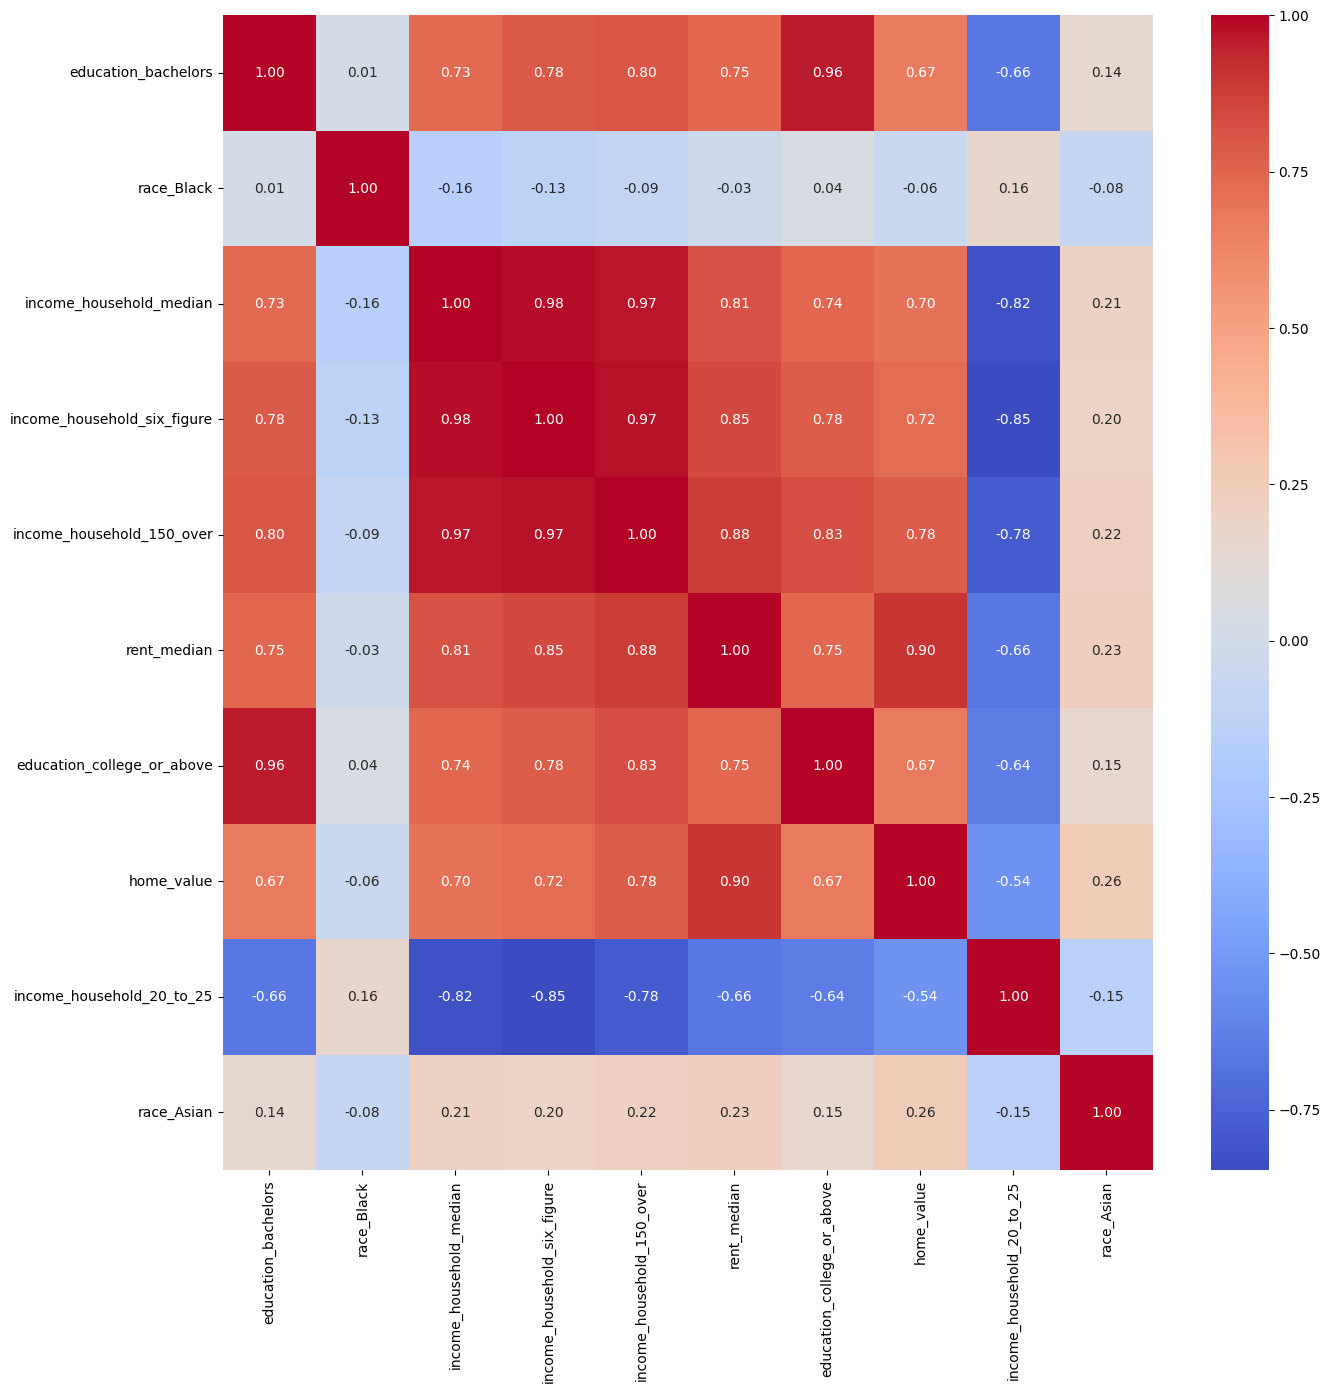

4015
Top Col:  Index(['education_bachelors', 'race_Black', 'income_household_median',
       'income_household_six_figure', 'income_household_150_over',
       'rent_median', 'education_college_or_above', 'home_value',
       'income_household_20_to_25', 'race_Asian'],
      dtype='object')


<ipython-input-23-791a4f77fdac>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype(float)


        bmi  bmi_filled
0       NaN   30.547027
1       NaN   29.409321
2       NaN   28.058143
3       NaN   28.058143
4     23.00         NaN
...     ...         ...
5787  29.60         NaN
5788    NaN   29.596155
5789  28.28         NaN
5790    NaN   29.686727
5791    NaN   27.684553

[5792 rows x 2 columns]


In [ ]:
# bmi filling
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

correlation_matrix = df.corr()

# Get the top 10 columns with the highest absolute correlation with 'bmi'
top_columns = correlation_matrix['bmi'].abs().sort_values(ascending=False).head(11).index[1:]

# Plot the heatmap for the top 10 columns
plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix[top_columns].loc[top_columns], annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

print(df['bmi'].isnull().sum())

print("Top Col: ", top_columns)

X = df[top_columns]
y = df['bmi']

# Identify rows with missing 'bmi' values
missing_bmi_mask = y.isnull()

# Separate the dataframe into features (X_train) and target (y_train) for non-missing values
X_train, y_train = X[~missing_bmi_mask], y[~missing_bmi_mask]

# Identify numerical columns and set their data types explicitly
numerical_cols = [col for col in X.columns if np.issubdtype(X[col].dtype, np.number)]


# Convert numerical columns to float
for col in numerical_cols:
    try:
        X[col] = X[col].astype(float)
    except ValueError:
        X[col] = pd.to_numeric(X[col], errors='coerce')
        X[col] = X[col].astype(float)


# Create transformers for numerical columns
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # You can choose another strategy
])

# Use ColumnTransformer to apply the numerical transformer to the numerical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
    ])

# Build the model pipeline
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', RandomForestRegressor())])

# Train the model on the rows where 'bmi' is not missing
model.fit(X_train, y_train)

# Predict missing 'bmi' values in the entire dataset
predicted_bmi = model.predict(X[missing_bmi_mask])

# Fill missing 'bmi' values with predictions
df.loc[missing_bmi_mask, 'bmi_filled'] = predicted_bmi

# Print the original 'bmi' and the new 'bmi_filled' columns
print(df[['bmi', 'bmi_filled']])

# Create a new column 'merged_bmi' with the merged output of 'bmi' and 'bmi_filled'
df['merged_bmi'] = df.apply(lambda row: row['bmi_filled'] if pd.notnull(row['bmi_filled']) else row['bmi'], axis=1)



In [ ]:
# patient_income column prediction

import pandas as pd


df['patient_income'] = (
    (df['income_household_under_5'] / 100) * 2500 +
    (df['income_household_5_to_10'] / 100) * 7500 +
    (df['income_household_10_to_15'] / 100) * 12500 +
    (df['income_household_15_to_20'] / 100) * 17500 +
    (df['income_household_20_to_25'] / 100) * 22500 +
    (df['income_household_25_to_35'] / 100) * 30000 +
    (df['income_household_35_to_50'] / 100) * 42500 +
    (df['income_household_50_to_75'] / 100) * 62500 +
    (df['income_household_75_to_100'] / 100) * 87500 +
    (df['income_household_100_to_150'] / 100) * 125000 +
    (df['income_household_150_over'] / 100) * 175000 +
    df['income_individual_median'] +
    df['income_household_median']
)
df['patient_income'] = df['patient_income'].fillna(0)

df['patient_income'] = df['patient_income'].astype(int)

print(df[['patient_income']])


      patient_income
0             172176
1             176069
2             213250
3             213250
4             183405
...              ...
5787          128143
5788          142806
5789          288685
5790          152502
5791          208761

[5792 rows x 1 columns]


In [ ]:
# Filling null vlaues of some column with mode
import pandas as pd

# Find columns with null values
columns_with_null = df.columns[df.isnull().any()].tolist()

# Replace null values in each column with its mode
for column in columns_with_null:
    mode_value = df[column].mode()[0]
    df[column] = df[column].fillna(mode_value)
print("Null values filled")

Null values filled


In [ ]:
# Rounding values in all numeric columns to 2 decimal places
import pandas as pd

df_rounded = df.round(2)
df = df_rounded
print(df_rounded)


      patient_id patient_race          payer_type patient_state  patient_zip3  \
0         573710        White            MEDICAID            IN           467   
1         593679        White          COMMERCIAL            FL           337   
2         184532     Hispanic            MEDICAID            CA           917   
3         447383     Hispanic  MEDICARE ADVANTAGE            CA           917   
4         687972        Black          COMMERCIAL            CA           900   
...          ...          ...                 ...           ...           ...   
5787      977076        White          COMMERCIAL            KY           404   
5788      922960        White          COMMERCIAL            IA           507   
5789      759690        White  MEDICARE ADVANTAGE            WA           980   
5790      911717        White          COMMERCIAL            OK           740   
5791      327597     Hispanic  MEDICARE ADVANTAGE            NY           114   

      patient_age patient_g

In [ ]:
# drop columns which are not required

# 'columns_to_drop' is a list of column names to drop
columns_to_drop = ['patient_race','payer_type', 'patient_state', 'patient_gender','bmi','breast_cancer_diagnosis_code','breast_cancer_diagnosis_desc',
                   'metastatic_cancer_diagnosis_code','metastatic_first_novel_treatment','metastatic_first_novel_treatment_type',
                   'Region','Division','limited_english','processed_text','patient_race_filled','bmi_filled']

# Drop the specified columns
df = df.drop(columns=columns_to_drop)
df.to_csv('test_final1.csv', index=False)
null_values = df.isnull().sum()
print("Null values in each column:")
print(null_values)


Null values in each column:
patient_id                                  0
patient_zip3                                0
patient_age                                 0
population                                  0
density                                     0
                                           ..
patient_F                                   0
breast_cancer_diagnosis_code_encoded        0
metastatic_cancer_diagnosis_code_encoded    0
merged_bmi                                  0
patient_income                              0
Length: 83, dtype: int64


EDA & Feature Engineering

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4801 entries, 0 to 4800
Data columns (total 83 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   patient_id                             4801 non-null   int64  
 1   patient_race                           2459 non-null   object 
 2   payer_type                             4117 non-null   object 
 3   patient_state                          4784 non-null   object 
 4   patient_zip3                           4801 non-null   int64  
 5   patient_age                            4801 non-null   int64  
 6   patient_gender                         4801 non-null   object 
 7   bmi                                    1472 non-null   float64
 8   breast_cancer_diagnosis_code           4801 non-null   object 
 9   breast_cancer_diagnosis_desc           4801 non-null   object 
 10  metastatic_cancer_diagnosis_code       4801 non-null   object 
 11  meta

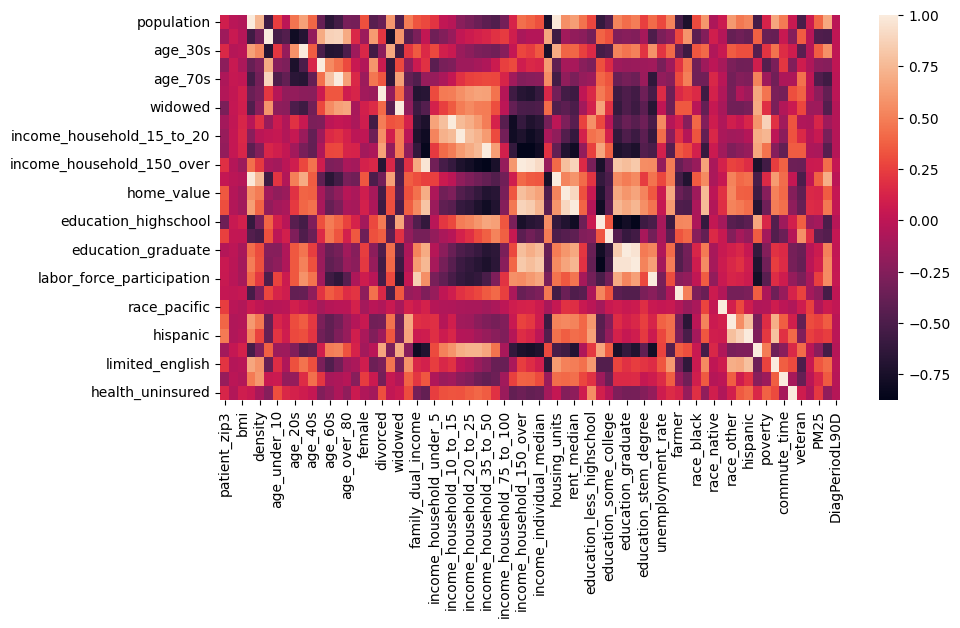

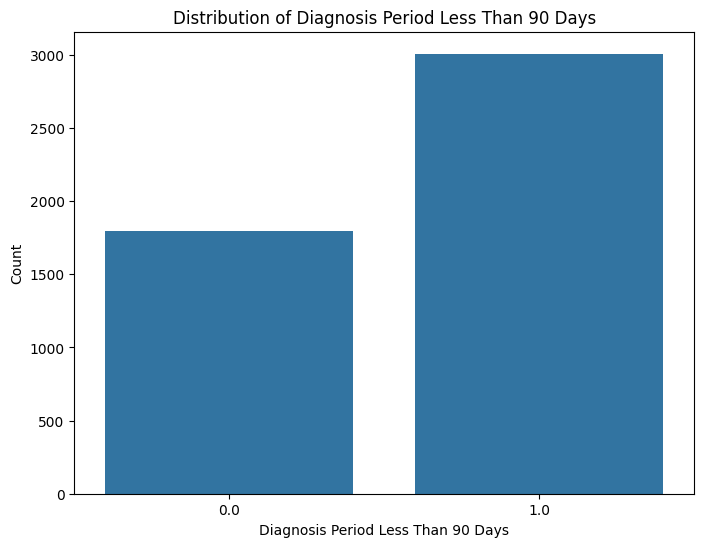

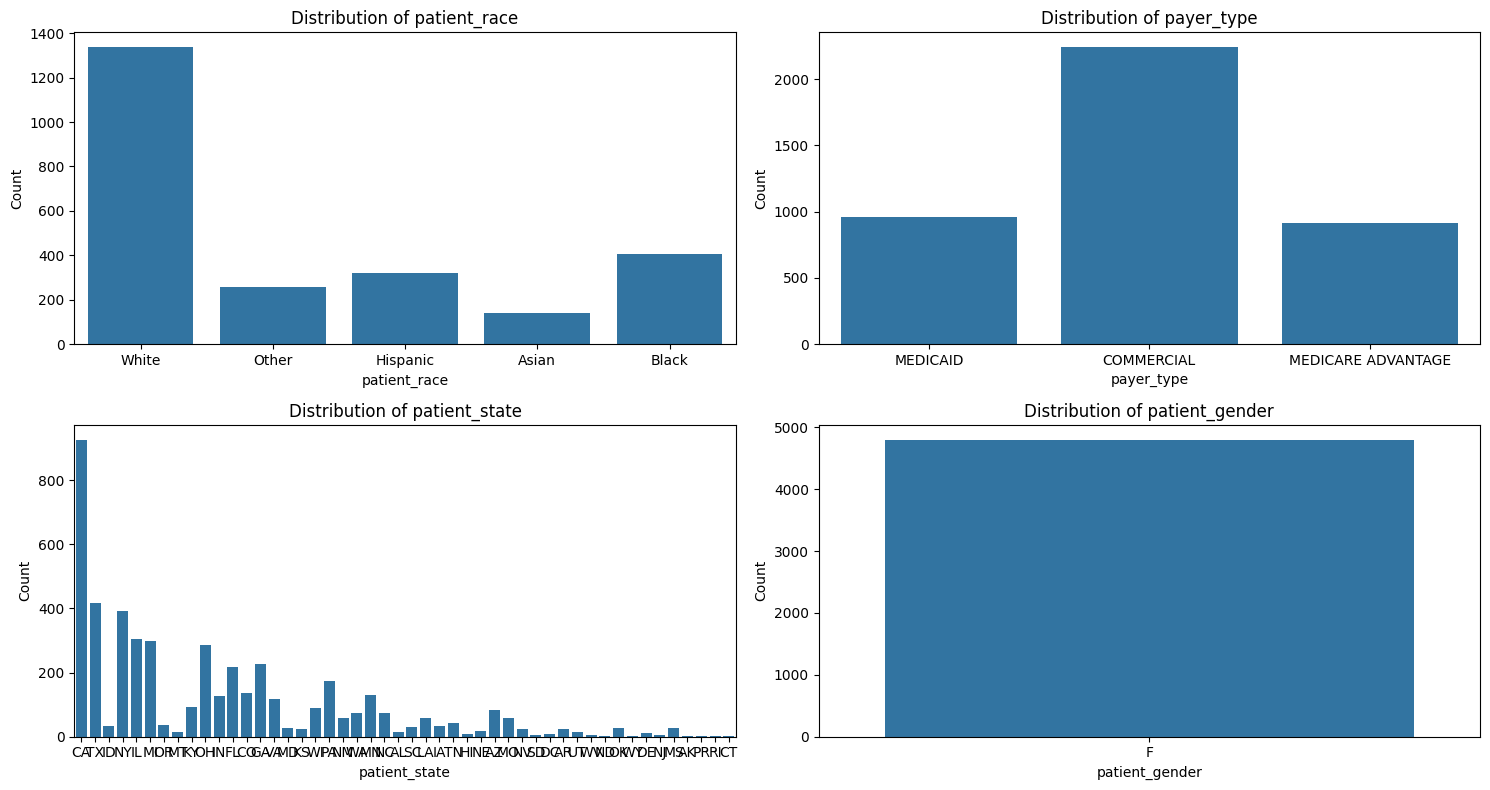

<ipython-input-5-a4fa9bb6e0c7>:63: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = train_data.corr()


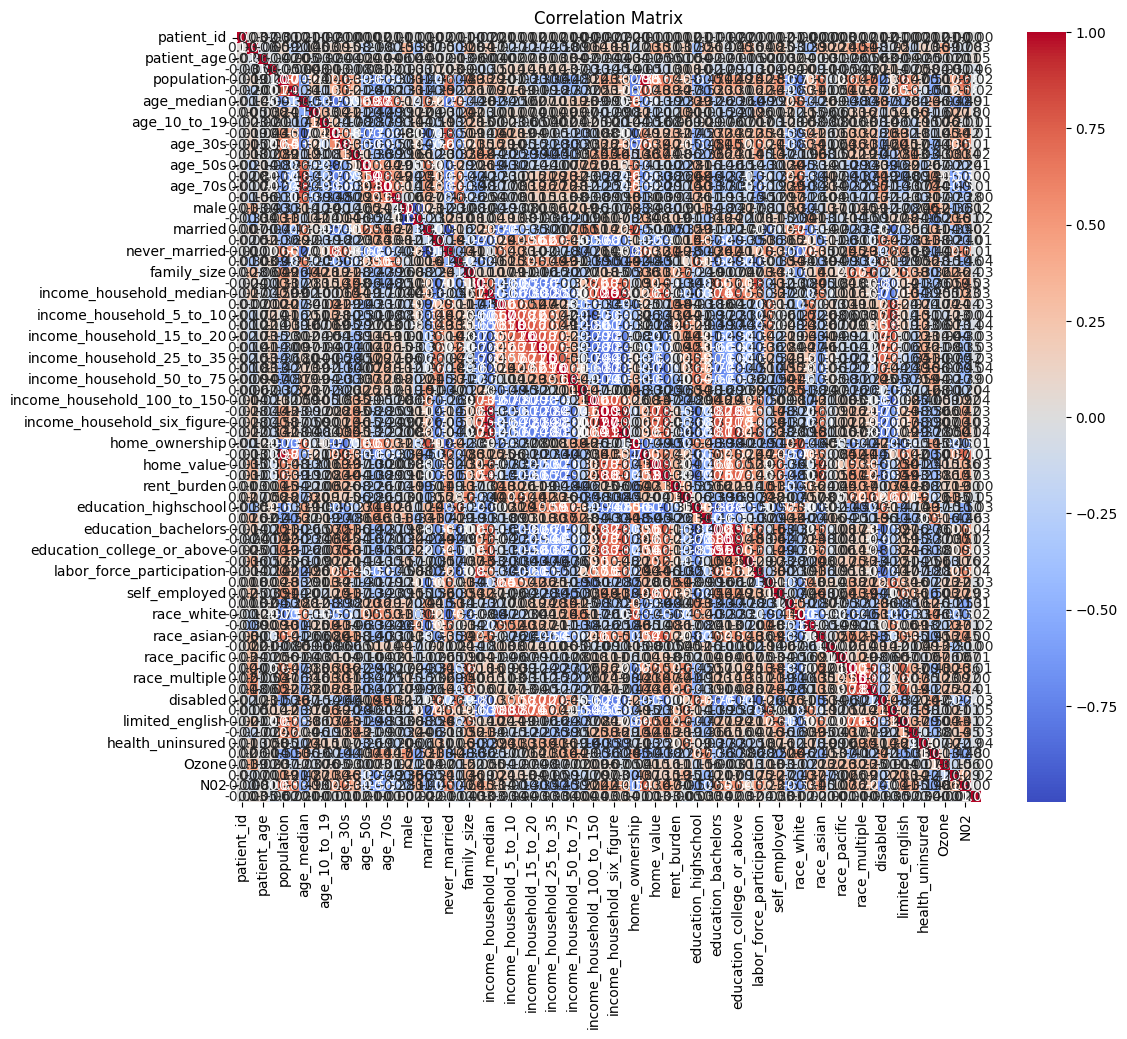

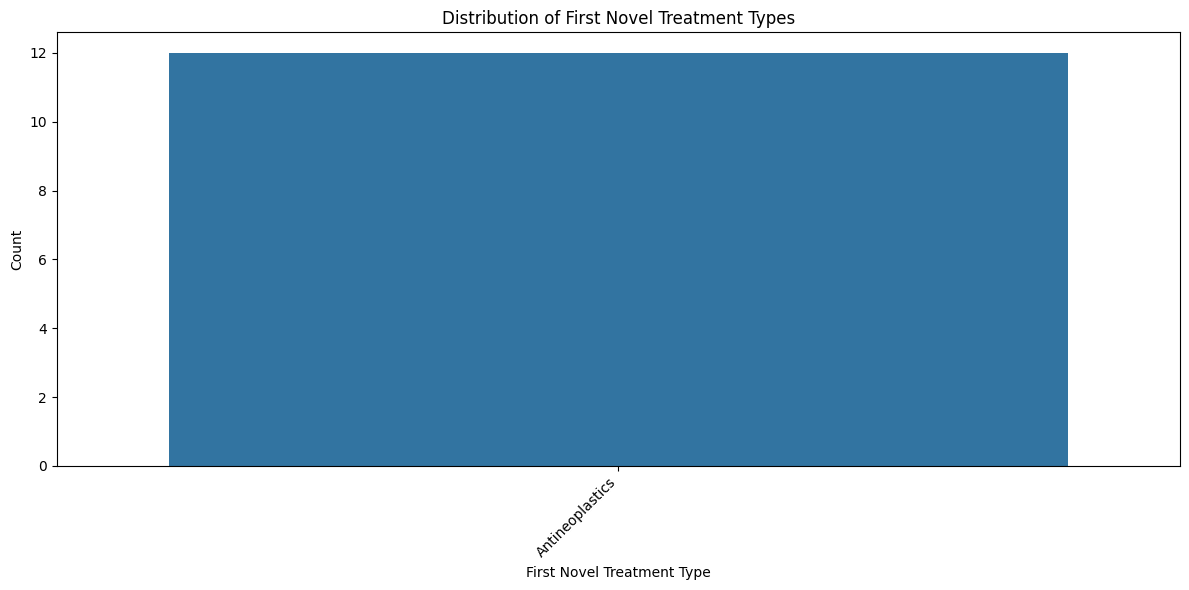

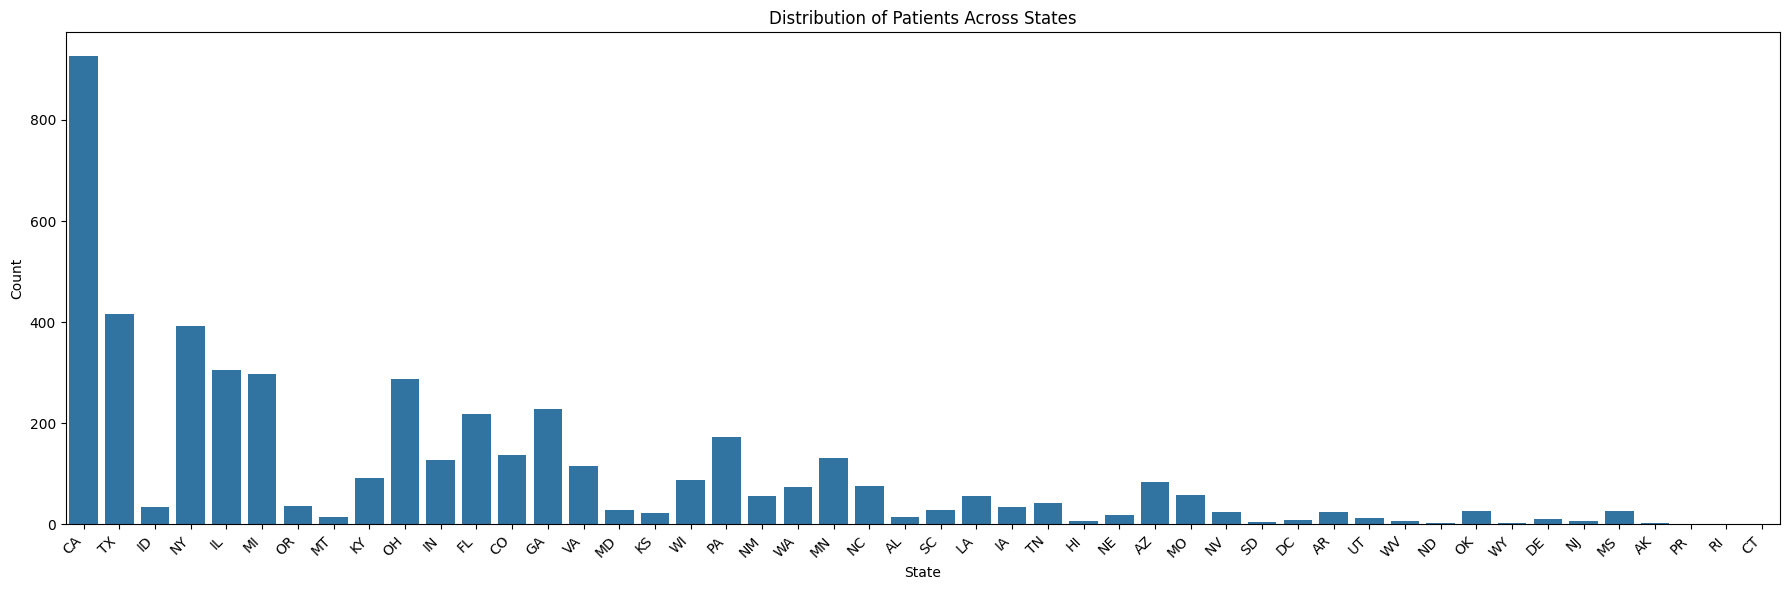

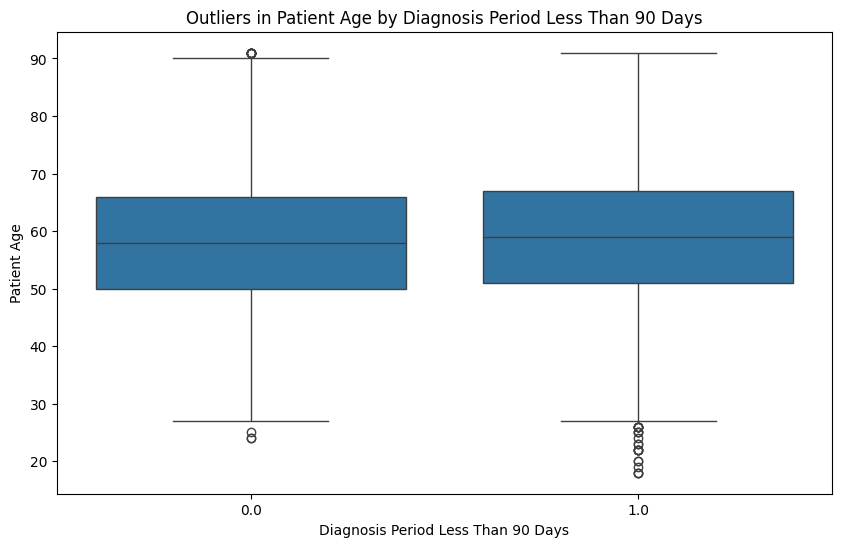

In [ ]:
# Import Libraries

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the un preprocessed Data
train_data = pd.read_csv('training.csv')

# Display basic information about the dataset
print(train_data.info())

# Summary Statistics
print(train_data.describe())

# Check Missing Values
print(train_data.isnull().sum())


corr_df = train_data.drop(['patient_id'],axis=1).select_dtypes(exclude='object').corr()

# only looking at correlations showing a coefficient higher than 0.01
corr_df = corr_df[abs(corr_df)>0.005].dropna(how='any',axis=0)
corr_df = corr_df[abs(corr_df)>0.005].dropna(how='any',axis=1)

plt.figure(figsize=(10,5))
mask = np.triu(np.ones_like(corr_df, dtype=bool))
sns.heatmap(corr_df)

# Distribution of Target Variable
plt.figure(figsize=(8, 6))
sns.countplot(x='DiagPeriodL90D', data=train_data)
plt.title('Distribution of Diagnosis Period Less Than 90 Days')
plt.xlabel('Diagnosis Period Less Than 90 Days')
plt.ylabel('Count')
plt.show()

# Explore Categorical Variables
categorical_variables = ['patient_race', 'payer_type', 'patient_state', 'patient_gender']
plt.figure(figsize=(15, 8))
for i, variable in enumerate(categorical_variables, 1):
    plt.subplot(2, 2, i)
    sns.countplot(x=variable, data=train_data)
    plt.title(f'Distribution of {variable}')
    plt.xlabel(variable)
    plt.ylabel('Count')
plt.tight_layout()
plt.show()

# # Explore Numeric Variables
# numeric_variables = ['patient_age', 'income_household_median', 'ozone']
# plt.figure(figsize=(15, 4))
# for i, variable in enumerate(numeric_variables, 1):
#     plt.subplot(1, 3, i)
#     sns.histplot(train_data[variable], bins=30, kde=True)
#     plt.title(f'Distribution of {variable}')
#     plt.xlabel(variable)
#     plt.ylabel('Count')
# plt.tight_layout()
# plt.show()

# Correlation Analysis
correlation_matrix = train_data.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

# Explore Time-Related Variables
plt.figure(figsize=(12, 6))
sns.countplot(x='metastatic_first_novel_treatment_type', data=train_data)
plt.title('Distribution of First Novel Treatment Types')
plt.xlabel('First Novel Treatment Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Geographic Analysis
plt.figure(figsize=(18, 6))
sns.countplot(x='patient_state', data=train_data)
plt.title('Distribution of Patients Across States')
plt.xlabel('State')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# # Toxic Air Quality Analysis
# plt.figure(figsize=(12, 8))
# sns.scatterplot(x='ozone', y='PM25', hue='DiagPeriodL90D', data=train_data)
# plt.title('Toxic Air Quality vs. Diagnosis Period Less Than 90 Days')
# plt.xlabel('Ozone')
# plt.ylabel('PM2.5')
# plt.legend(title='Diagnosis Period Less Than 90 Days', loc='upper right', labels=['No', 'Yes'])
# plt.show()

# Feature Engineering (if needed)
# Outlier Detection and Handling
plt.figure(figsize=(10, 6))
sns.boxplot(x='DiagPeriodL90D', y='patient_age', data=train_data)
plt.title('Outliers in Patient Age by Diagnosis Period Less Than 90 Days')
plt.xlabel('Diagnosis Period Less Than 90 Days')
plt.ylabel('Patient Age')
plt.show()


# Save the Cleaned Data
# train_data.to_csv('cleaned_train_data.csv', index=False)



In [ ]:
import pandas as pd
df = pd.read_csv("train_final1.csv")

In [ ]:
# bin edges
age_bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
# bin labels for each bin
age_labels = ['0-10', '11-20', '21-30', '31-40', '41-50','51-60','61-70', '71-80','81-90','90+']

df['age_group'] = pd.cut(df['patient_age'], bins=age_bins, labels=age_labels, right=False)

print(df[['patient_age', 'age_group']].head(20))

    patient_age age_group
0            84     81-90
1            62     61-70
2            43     41-50
3            45     41-50
4            55     51-60
5            66     61-70
6            51     51-60
7            60     61-70
8            82     81-90
9            64     61-70
10           67     61-70
11           66     61-70
12           58     51-60
13           82     81-90
14           58     51-60
15           62     61-70
16           41     41-50
17           83     81-90
18           75     71-80
19           60     61-70


In [ ]:

# bin edges
bmi_bins = [0, 18.5, 25, 30, float('inf')]
# bin labels for each bin
bmi_labels = ['Underweight', 'Normal Weight', 'Overweight', 'Obese']

df['bmi_category'] = pd.cut(df['merged_bmi'], bins=bmi_bins, labels=bmi_labels, right=False)

print(df[['merged_bmi', 'bmi_category']].head())


   merged_bmi bmi_category
0       30.52        Obese
1       28.49   Overweight
2       38.09        Obese
3       27.43   Overweight
4       26.87   Overweight


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


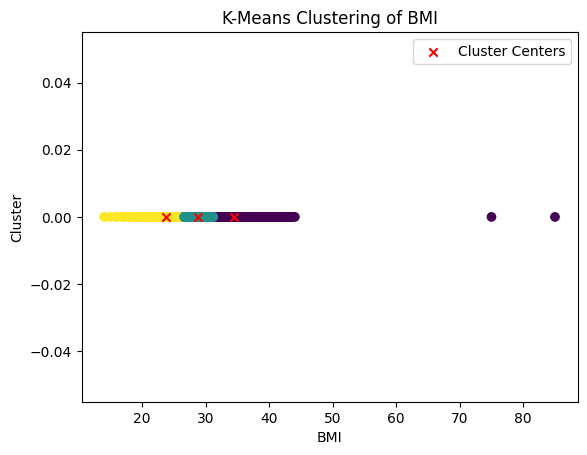

   merged_bmi  bmi_cluster
0       30.52            1
1       28.49            1
2       38.09            0
3       27.43            1
4       26.87            1


In [ ]:

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
df.dropna(inplace=True)
bmi_data = df[['merged_bmi']]

num_clusters = 3

# Performing K-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(bmi_data)

# Obtaining cluster centers and labels
cluster_centers = kmeans.cluster_centers_
cluster_labels = kmeans.labels_

# Assigning cluster labels to DataFrame
df['bmi_cluster'] = cluster_labels

# Visualizing clusters
plt.scatter(df['merged_bmi'], [0] * len(df), c=df['bmi_cluster'], cmap='viridis')
plt.scatter(cluster_centers, [0] * num_clusters, marker='x', color='red', label='Cluster Centers')
plt.xlabel('BMI')
plt.ylabel('Cluster')
plt.title('K-Means Clustering of BMI')
plt.legend()
plt.show()

print(df[['merged_bmi', 'bmi_cluster']].head())


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


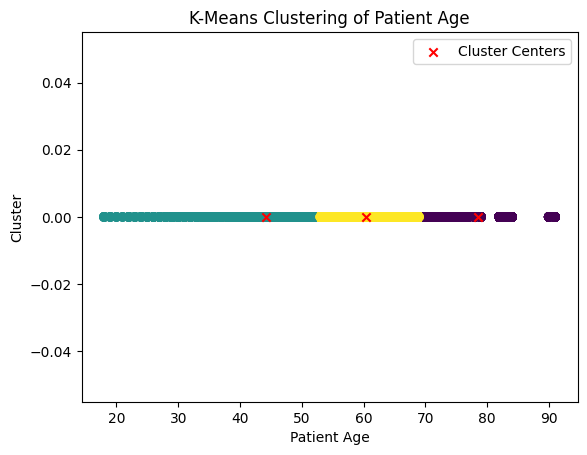

   patient_age  age_cluster
0           84            0
1           62            2
2           43            1
3           45            1
4           55            2


In [ ]:

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

age_data = df[['patient_age']]

num_clusters = 3

# Performing K-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(age_data)

# Obtaining cluster centers and labels
cluster_centers = kmeans.cluster_centers_
cluster_labels = kmeans.labels_

# Assigning cluster labels to DataFrame
df['age_cluster'] = cluster_labels

#Visualizing clusters
plt.scatter(df['patient_age'], [0] * len(df), c=df['age_cluster'], cmap='viridis')
plt.scatter(cluster_centers, [0] * num_clusters, marker='x', color='red', label='Cluster Centers')
plt.xlabel('Patient Age')
plt.ylabel('Cluster')
plt.title('K-Means Clustering of Patient Age')
plt.legend()
plt.show()

print(df[['patient_age', 'age_cluster']].head())


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


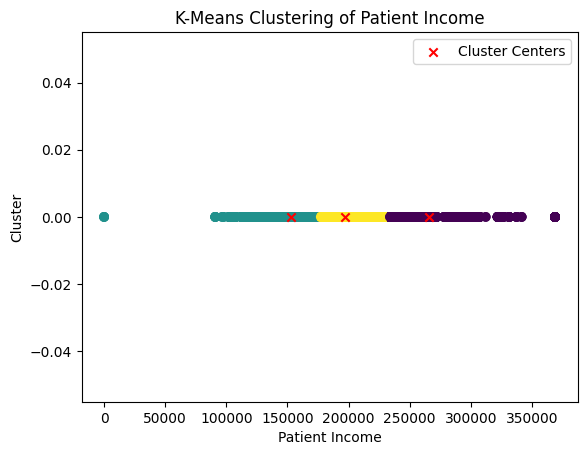

   patient_income  income_cluster
0          141003               1
1          246510               0
2          215720               2
3          287354               0
4          159516               1


In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

income_data = df[['patient_income']]
num_clusters = 3

# Performing K-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(income_data)

# Obtaining cluster centers and labels
cluster_centers = kmeans.cluster_centers_
cluster_labels = kmeans.labels_

# Assigning cluster labels to DataFrame
df['income_cluster'] = cluster_labels

# Visualizing clusters
plt.scatter(df['patient_income'], [0] * len(df), c=df['income_cluster'], cmap='viridis')
plt.scatter(cluster_centers, [0] * num_clusters, marker='x', color='red', label='Cluster Centers')
plt.xlabel('Patient Income')
plt.ylabel('Cluster')
plt.title('K-Means Clustering of Patient Income')
plt.legend()
plt.show()

print(df[['patient_income', 'income_cluster']].head())


In [ ]:

# Visualizing the distribution and proportion of cancer cases across age clusters and diagnosis periods.
cluster_diagnosis_df = df[['age_cluster', 'DiagPeriodL90D']]
cancer_cases_in_clusters = cluster_diagnosis_df.groupby(['age_cluster', 'DiagPeriodL90D']).size().unstack(fill_value=0)
print(cancer_cases_in_clusters)


DiagPeriodL90D     0     1
age_cluster               
0                887  1749
1               1624  2339
2               2335  3972


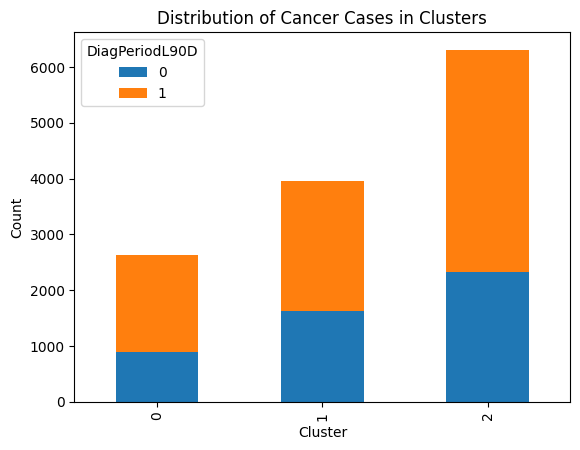

In [ ]:
cancer_cases_in_clusters.plot(kind='bar', stacked=True)
plt.title('Distribution of Cancer Cases in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()


In [ ]:
cluster_counts = cluster_diagnosis_df['age_cluster'].value_counts()
cancer_proportion_in_clusters = cancer_cases_in_clusters / cluster_counts[:, None]
print(cancer_proportion_in_clusters)


DiagPeriodL90D         0      1
age_cluster                    
0               0.166667  0.500
1               0.625000  0.875
2               0.250000  0.750


<ipython-input-26-ff47bca06fa8>:2: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  cancer_proportion_in_clusters = cancer_cases_in_clusters / cluster_counts[:, None]


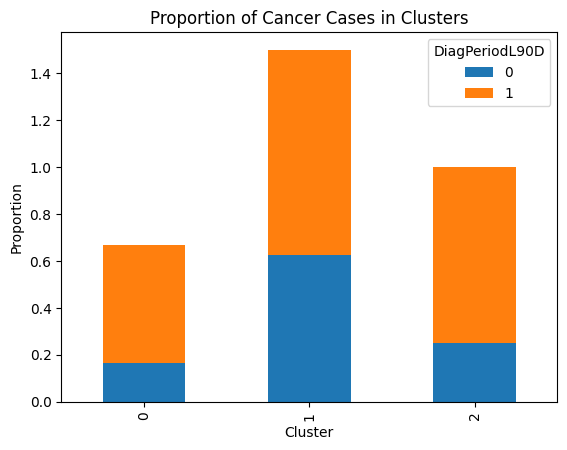

In [ ]:
cancer_proportion_in_clusters.plot(kind='bar', stacked=True)
plt.title('Proportion of Cancer Cases in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Proportion')
plt.show()


In [ ]:
"""The features that have low p-values in the ANOVA test are the ones that show significant
differences across different categories of the patient_race column. These features are likely to be informative
for predicting or imputing values in the patient_race column
"""


import pandas as pd
from scipy.stats import f_oneway

# df = pd.read_csv('training//training_bmi.csv')
df = pd.read_csv('training.csv')

numerical_columns = [
    'patient_zip3', 'patient_age', 'population', 'density', 'age_median', 'age_under_10',
    'age_10_to_19', 'age_20s', 'age_30s', 'age_40s', 'age_50s', 'age_60s', 'age_70s', 'age_over_80',
    'male', 'female', 'married', 'divorced', 'never_married', 'widowed', 'family_size',
    'family_dual_income', 'income_household_median', 'income_household_under_5',
    'income_household_5_to_10', 'income_household_10_to_15', 'income_household_15_to_20',
    'income_household_20_to_25', 'income_household_25_to_35', 'income_household_35_to_50',
    'income_household_50_to_75', 'income_household_75_to_100', 'income_household_100_to_150',
    'income_household_150_over', 'income_household_six_figure', 'income_individual_median',
    'home_ownership', 'housing_units', 'home_value', 'rent_median', 'rent_burden',
    'education_less_highschool', 'education_highschool', 'education_some_college',
    'education_bachelors', 'education_graduate', 'education_college_or_above',
    'education_stem_degree', 'labor_force_participation', 'unemployment_rate',
    'self_employed', 'farmer', 'race_white', 'race_black', 'race_asian', 'race_native',
    'race_pacific', 'race_other', 'race_multiple', 'hispanic'
]

# DataFrame to store the results
anova_results = pd.DataFrame(columns=['Feature', 'F-statistic', 'P-value'])

for feature in numerical_columns:
    # Filtering out NaN values
    non_nan_data = df[[feature, 'patient_race']].dropna()

    # ANOVA test
    group_by_race = non_nan_data.groupby('patient_race')[feature]
    anova_result = f_oneway(*[group.values for name, group in group_by_race])

    # results
    anova_results = anova_results.append({
        'Feature': feature,
        'F-statistic': anova_result.statistic,
        'P-value': anova_result.pvalue
    }, ignore_index=True)

print(anova_results.sort_values(by='P-value'))



<ipython-input-20-a4eba7aedc8d>:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  anova_results = anova_results.append({
<ipython-input-20-a4eba7aedc8d>:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  anova_results = anova_results.append({
<ipython-input-20-a4eba7aedc8d>:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  anova_results = anova_results.append({
<ipython-input-20-a4eba7aedc8d>:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  anova_results = anova_results.append({
<ipython-input-20-a4eba7aedc8d>:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat 

                        Feature  F-statistic        P-value
53                   race_black   483.132764   0.000000e+00
52                   race_white   422.108620  4.940656e-324
59                     hispanic   413.065220  1.139735e-317
58                race_multiple   305.021523  7.288624e-241
57                   race_other   300.529906  1.402929e-237
20                  family_size   269.729944  7.533084e-215
16                      married   220.024805  2.141494e-177
18                never_married   213.345402  2.750303e-172
54                   race_asian   207.207367  1.412584e-167
36               home_ownership   197.831863  2.379232e-160
2                    population   190.271663  1.688999e-154
41    education_less_highschool   190.092572  2.325713e-154
39                  rent_median   172.116112  2.402859e-140
0                  patient_zip3   161.092269  1.094999e-131
38                   home_value   148.389025  1.216980e-121
37                housing_units   142.95

<ipython-input-20-a4eba7aedc8d>:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  anova_results = anova_results.append({
<ipython-input-20-a4eba7aedc8d>:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  anova_results = anova_results.append({
<ipython-input-20-a4eba7aedc8d>:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  anova_results = anova_results.append({
<ipython-input-20-a4eba7aedc8d>:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  anova_results = anova_results.append({
<ipython-input-20-a4eba7aedc8d>:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat 

# **Univariate Feature Selection**:

SelectKBest: Select the top k features based on univariate statistical tests.
SelectPercentile: Select the top features based on a percentage of the highest scores.


In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import pandas as pd

# Load your data (replace 'your_dataset.csv' with your actual dataset)
train_data = pd.read_csv("training.csv")
# train_data = pd.read_csv("train_final1.csv")

# Drop the patient_id column
train_data = train_data.drop(['patient_id'], axis=1)

# Handle missing values
# Separate numerical and categorical features
numerical_features = train_data.select_dtypes(include=['float64']).columns
categorical_features = train_data.select_dtypes(include=['object']).columns

# Impute missing values for numerical features
numerical_imputer = SimpleImputer(strategy='mean')
train_data[numerical_features] = numerical_imputer.fit_transform(train_data[numerical_features])

# Impute missing values for categorical features
categorical_imputer = SimpleImputer(strategy='most_frequent')
train_data[categorical_features] = categorical_imputer.fit_transform(train_data[categorical_features])

# One-hot encode categorical variables
train_data = pd.get_dummies(train_data, columns=categorical_features)

# Split the data into features (X) and target variable (y)
X = train_data.drop(columns=["DiagPeriodL90D"])
y = train_data["DiagPeriodL90D"]

# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# SelectKBest with ANOVA F-statistic as the score function (for classification problems)
k = 10
selector = SelectKBest(score_func=f_classif, k=k)
X_train_selected = selector.fit_transform(X_train, y_train)

# Get the indices of the selected features
selected_feature_indices = selector.get_support(indices=True)

# Get the names of the selected features
selected_feature_names = X_train.columns[selected_feature_indices]

# Create a DataFrame with selected features
selected_features_df = pd.DataFrame(X_train_selected, columns=selected_feature_names)

# Print the names of selected features
print("Selected Features:")
print(selected_feature_names)


Selected Features:
Index(['breast_cancer_diagnosis_code_1744',
       'breast_cancer_diagnosis_code_1748',
       'breast_cancer_diagnosis_code_1749',
       'breast_cancer_diagnosis_code_C50911',
       'breast_cancer_diagnosis_code_C50912',
       'breast_cancer_diagnosis_desc_Malignant neoplasm of breast (female), unspecified',
       'breast_cancer_diagnosis_desc_Malignant neoplasm of other specified sites of female breast',
       'breast_cancer_diagnosis_desc_Malignant neoplasm of unsp site of right female breast',
       'breast_cancer_diagnosis_desc_Malignant neoplasm of unspecified site of left female breast',
       'breast_cancer_diagnosis_desc_Malignant neoplasm of upper-outer quadrant of female breast'],
      dtype='object')


/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [128 153 162 205 207 254 274] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [ ]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import pandas as pd

# Load your data (replace 'your_dataset.csv' with your actual dataset)
train_data = pd.read_csv("training.csv")

# Drop the patient_id column
train_data = train_data.drop(['patient_id'], axis=1)

# Handle missing values
# Separate numerical and categorical features
numerical_features = train_data.select_dtypes(include=['float64']).columns
categorical_features = train_data.select_dtypes(include=['object']).columns

# Impute missing values for numerical features
numerical_imputer = SimpleImputer(strategy='mean')
train_data[numerical_features] = numerical_imputer.fit_transform(train_data[numerical_features])

# Impute missing values for categorical features
categorical_imputer = SimpleImputer(strategy='most_frequent')
train_data[categorical_features] = categorical_imputer.fit_transform(train_data[categorical_features])

# One-hot encode categorical variables
train_data = pd.get_dummies(train_data, columns=categorical_features)

# Split the data into features (X) and target variable (y)
X = train_data.drop(columns=["DiagPeriodL90D"])
y = train_data["DiagPeriodL90D"]

# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a base classifier (you can use any other classifier of your choice)
base_classifier = RandomForestClassifier()

# Create the RFE model and select 10 features
n_features_to_select = 10
rfe = RFE(estimator=base_classifier, n_features_to_select=n_features_to_select)
X_train_rfe = rfe.fit_transform(X_train, y_train)

# Get the names of the selected features
selected_feature_names = X_train.columns[rfe.support_]

# Create a DataFrame with selected features
selected_features_df = pd.DataFrame(X_train_rfe, columns=selected_feature_names)

# Print the names of selected features
print("Selected Features:")
print(selected_feature_names)


Selected Features:
Index(['patient_zip3', 'patient_age', 'bmi', 'age_over_80',
       'income_household_25_to_35', 'education_bachelors', 'commute_time',
       'breast_cancer_diagnosis_code_1749',
       'breast_cancer_diagnosis_desc_Malignant neoplasm of breast (female), unspecified',
       'breast_cancer_diagnosis_desc_Malignant neoplasm of upper-outer quadrant of female breast'],
      dtype='object')


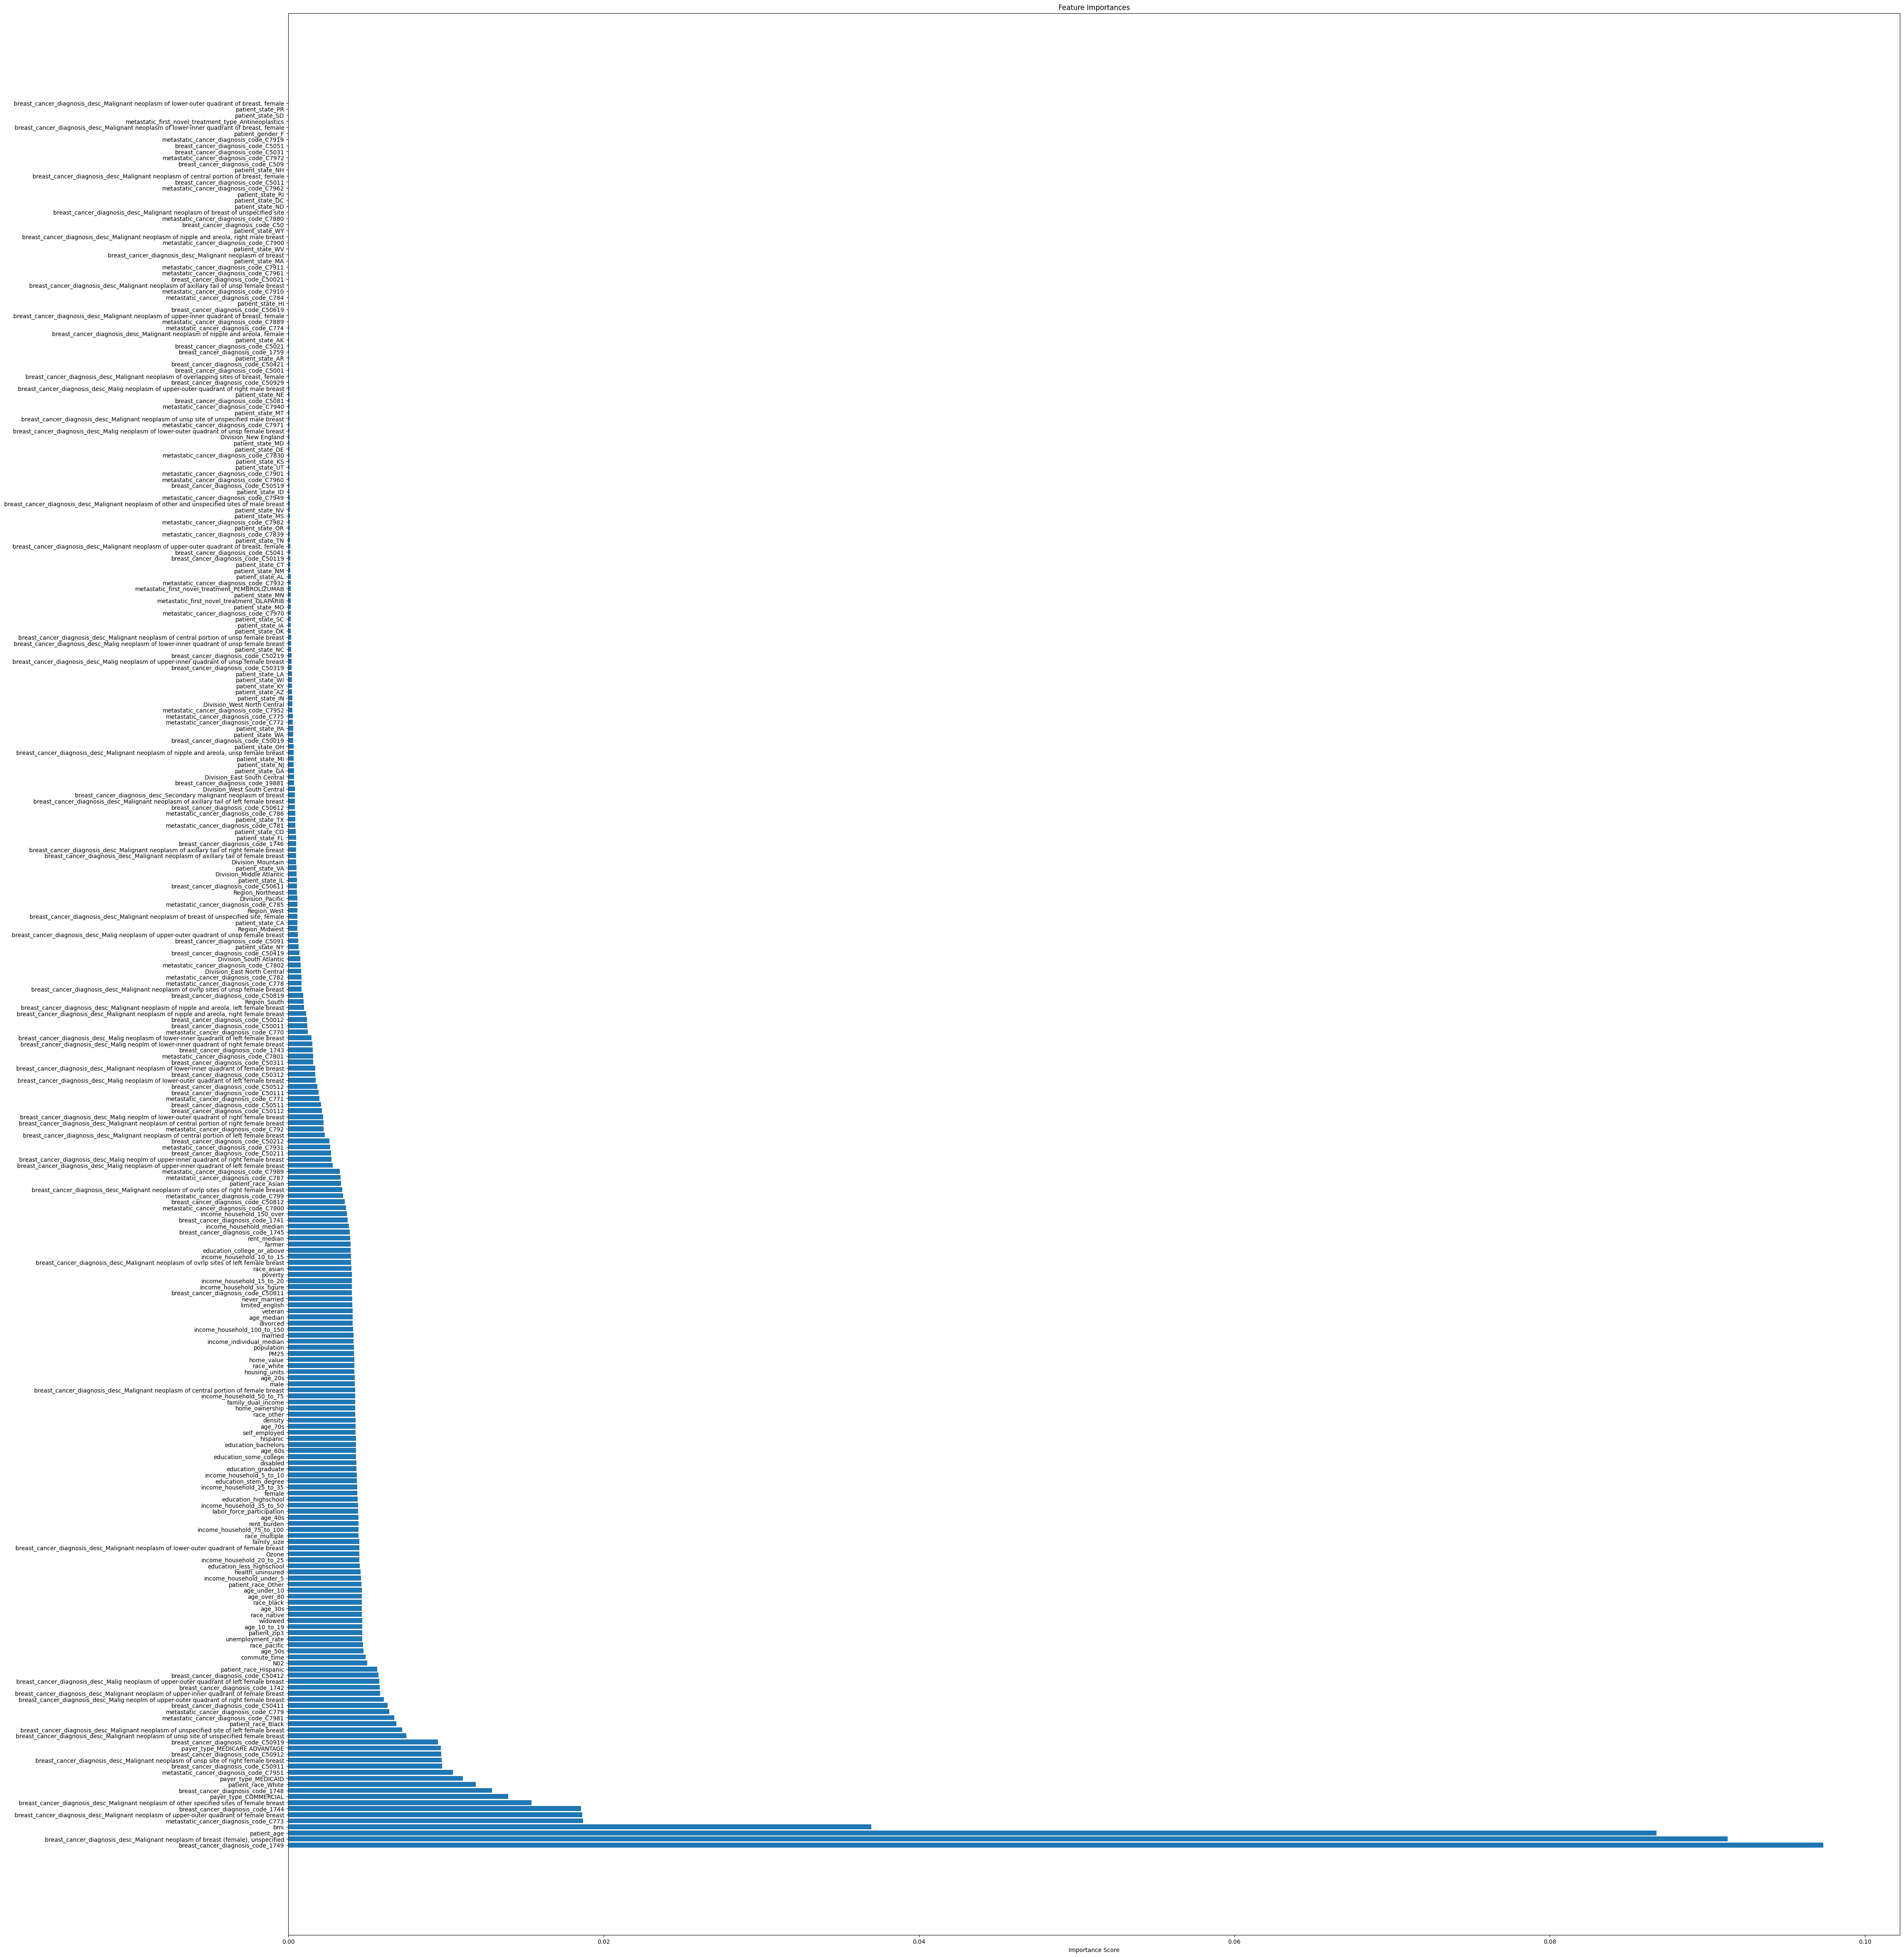

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt

# Load your data (replace 'your_dataset.csv' with your actual dataset)
train_data = pd.read_csv("training.csv")

# Drop the patient_id column
train_data = train_data.drop(['patient_id'], axis=1)

# Handle missing values
# Separate numerical and categorical features
numerical_features = train_data.select_dtypes(include=['float64']).columns
categorical_features = train_data.select_dtypes(include=['object']).columns

# Impute missing values for numerical features
numerical_imputer = SimpleImputer(strategy='mean')
train_data[numerical_features] = numerical_imputer.fit_transform(train_data[numerical_features])

# Impute missing values for categorical features
categorical_imputer = SimpleImputer(strategy='most_frequent')
train_data[categorical_features] = categorical_imputer.fit_transform(train_data[categorical_features])

# One-hot encode categorical variables
train_data = pd.get_dummies(train_data, columns=categorical_features)

# Split the data into features (X) and target variable (y)
X = train_data.drop(columns=["DiagPeriodL90D"])
y = train_data["DiagPeriodL90D"]

# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model to the training data
rf_classifier.fit(X_train, y_train)

# Get feature importances
feature_importances = rf_classifier.feature_importances_

# Get the names of features
feature_names = X_train.columns

# Create a DataFrame with feature names and their importance scores
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(50, 60))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance Score')
plt.title('Feature Importances')
plt.show()


Number of missing values in BMI column: 8965


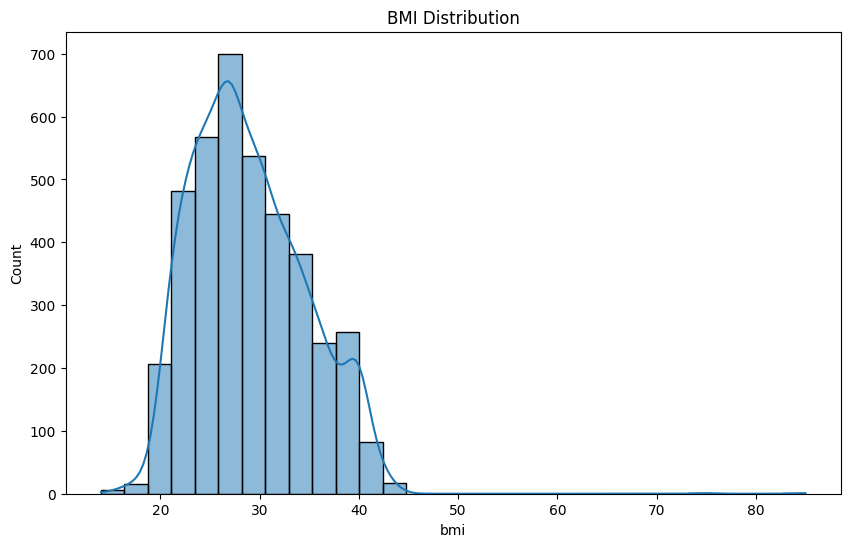


Summary Statistics:
count    3941.000000
mean       28.984539
std         5.696906
min        14.000000
25%        24.660000
50%        28.190000
75%        32.920000
max        85.000000
Name: bmi, dtype: float64

Correlation with BMI:
bmi                            1.000000
income_household_35_to_50      0.095446
income_household_25_to_35      0.094422
education_highschool           0.090453
income_household_20_to_25      0.088759
                                 ...   
home_value                    -0.090552
rent_median                   -0.097696
income_household_median       -0.104458
income_household_150_over     -0.104607
income_household_six_figure   -0.106262
Name: bmi, Length: 72, dtype: float64


<ipython-input-32-2aec679ecbc8>:25: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


0             Obese
1        Overweight
2             Obese
3             Obese
4             Obese
            ...    
12901         Obese
12902         Obese
12903    Overweight
12904         Obese
12905         Obese
Name: bmi_category, Length: 12906, dtype: object

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the Data
df = pd.read_csv('training.csv')
bmi_column = df['bmi']

# 1. Missing Values
missing_values = bmi_column.isnull().sum()
print(f"Number of missing values in BMI column: {missing_values}")

# 2. Distribution
plt.figure(figsize=(10, 6))
sns.histplot(bmi_column.dropna(), bins=30, kde=True)
plt.title('BMI Distribution')
plt.show()

# 3. Summary Statistics
summary_stats = bmi_column.describe()
print("\nSummary Statistics:")
print(summary_stats)

# 4. Correlation with Other Features
correlation_matrix = df.corr()
bmi_correlation = correlation_matrix['bmi'].sort_values(ascending=False)
print("\nCorrelation with BMI:")
print(bmi_correlation)

# 5. BMI Categories
def categorize_bmi(bmi):
    if bmi < 18.5:
        return 'Underweight'
    elif 18.5 <= bmi < 25:
        return 'Normal Weight'
    elif 25 <= bmi < 30:
        return 'Overweight'
    else:
        return 'Obese'

df['bmi_category'] = df['bmi'].apply(categorize_bmi)

df['bmi_category']

<ipython-input-33-bc55ee819539>:13: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


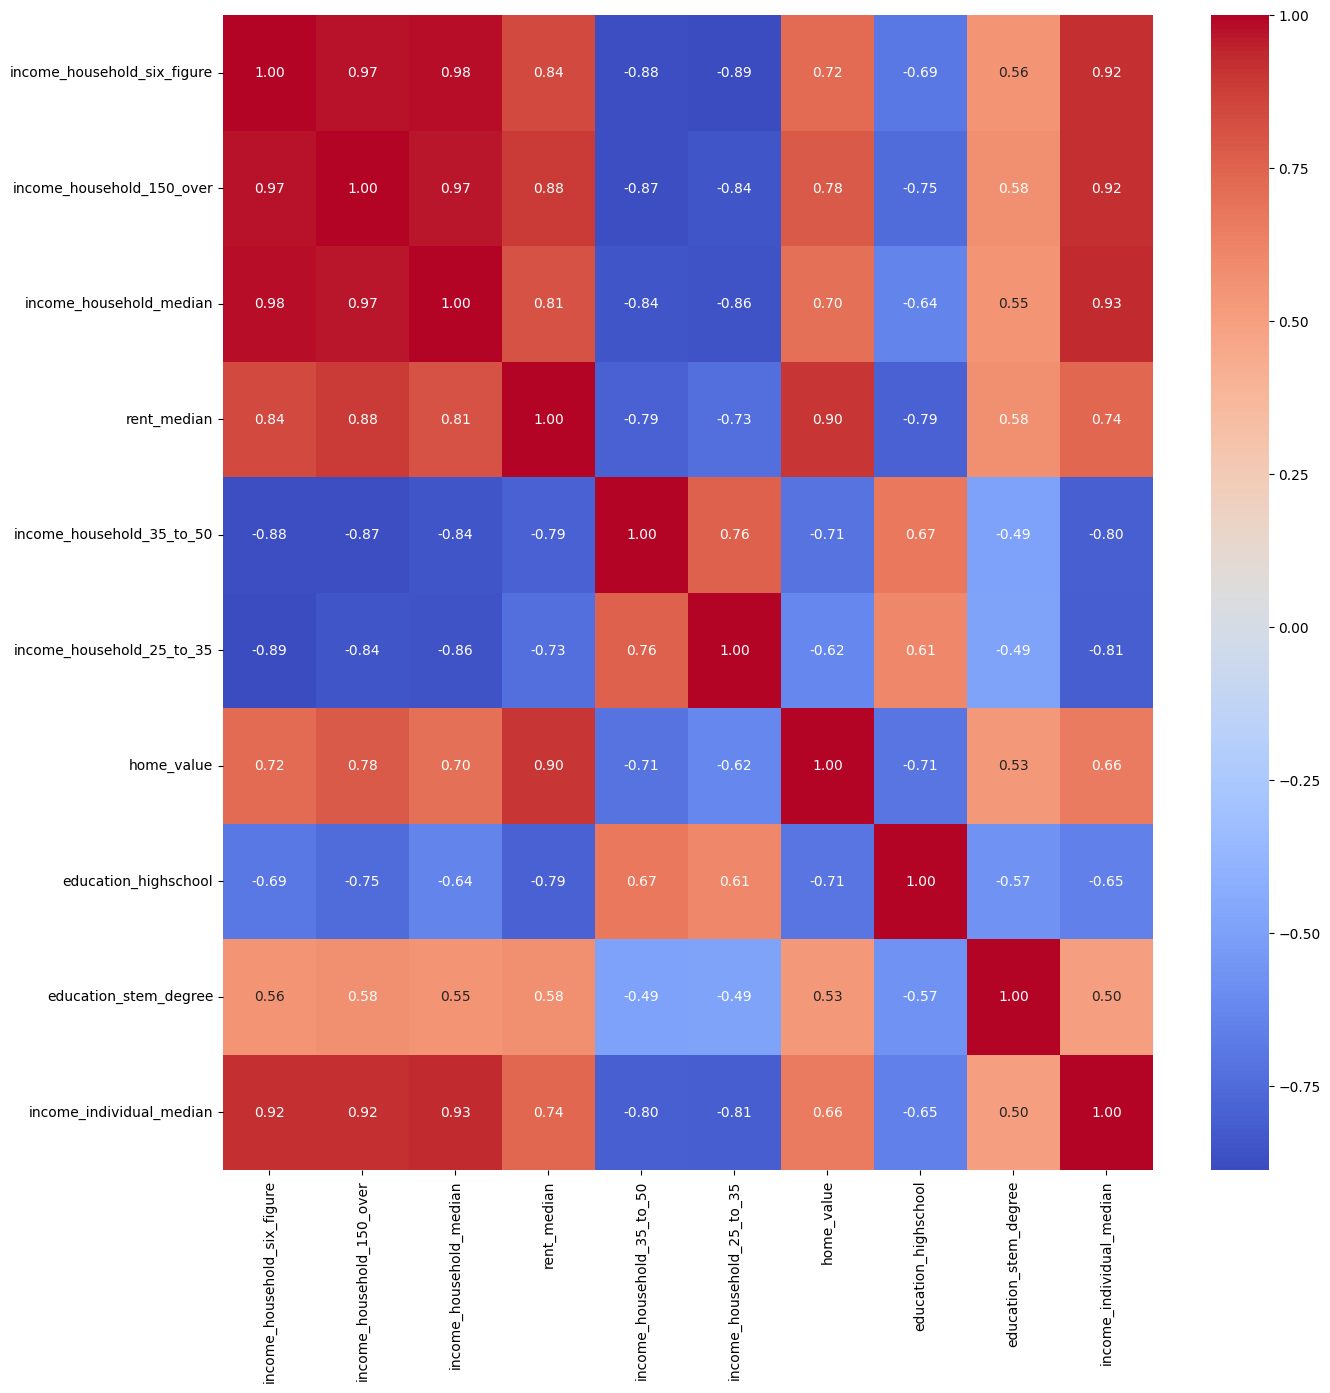

8965
Top Col:  Index(['income_household_six_figure', 'income_household_150_over',
       'income_household_median', 'rent_median', 'income_household_35_to_50',
       'income_household_25_to_35', 'home_value', 'education_highschool',
       'education_stem_degree', 'income_individual_median'],
      dtype='object')
         bmi  bmi_filled
0        NaN   30.655024
1      28.49         NaN
2      38.09         NaN
3        NaN   27.512093
4        NaN   26.877028
...      ...         ...
12901  32.11         NaN
12902    NaN   26.245347
12903  29.24         NaN
12904  31.00         NaN
12905    NaN   31.077162

[12906 rows x 2 columns]


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd

# Load the Data
df = pd.read_csv('training.csv')

correlation_matrix = df.corr()

# Get the top 10 columns with the highest absolute correlation with 'bmi'
top_columns = correlation_matrix['bmi'].abs().sort_values(ascending=False).head(11).index[1:]

# Plot the heatmap for the top 10 columns
plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix[top_columns].loc[top_columns], annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

print(df['bmi'].isnull().sum())

print("Top Col: ", top_columns)

# Assuming X contains features and y contains BMI
X = df[top_columns]
y = df['bmi']

# Identify rows with missing 'bmi' values
missing_bmi_mask = y.isnull()

# Separate the dataframe into features (X_train) and target (y_train) for non-missing values
X_train, y_train = X[~missing_bmi_mask], y[~missing_bmi_mask]

# Identify numerical columns
numerical_cols = X.select_dtypes(exclude=['object']).columns.tolist()

# Create transformers for numerical columns
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # You can choose another strategy
])

# Use ColumnTransformer to apply the numerical transformer to the numerical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
    ])

# Build the model pipeline
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', RandomForestRegressor())])

# Train the model on the rows where 'bmi' is not missing
model.fit(X_train, y_train)

# Predict missing 'bmi' values in the entire dataset
predicted_bmi = model.predict(X[missing_bmi_mask])

# Fill missing 'bmi' values with predictions
df.loc[missing_bmi_mask, 'bmi_filled'] = predicted_bmi

# Print the original 'bmi' and the new 'bmi_filled' columns
print(df[['bmi', 'bmi_filled']])

# Create a new column 'merged_bmi' with the merged output of 'bmi' and 'bmi_filled'
df['merged_bmi'] = df.apply(lambda row: row['bmi_filled'] if pd.notnull(row['bmi_filled']) else row['bmi'], axis=1)

df.to_csv('training_bmi.csv', index=False)


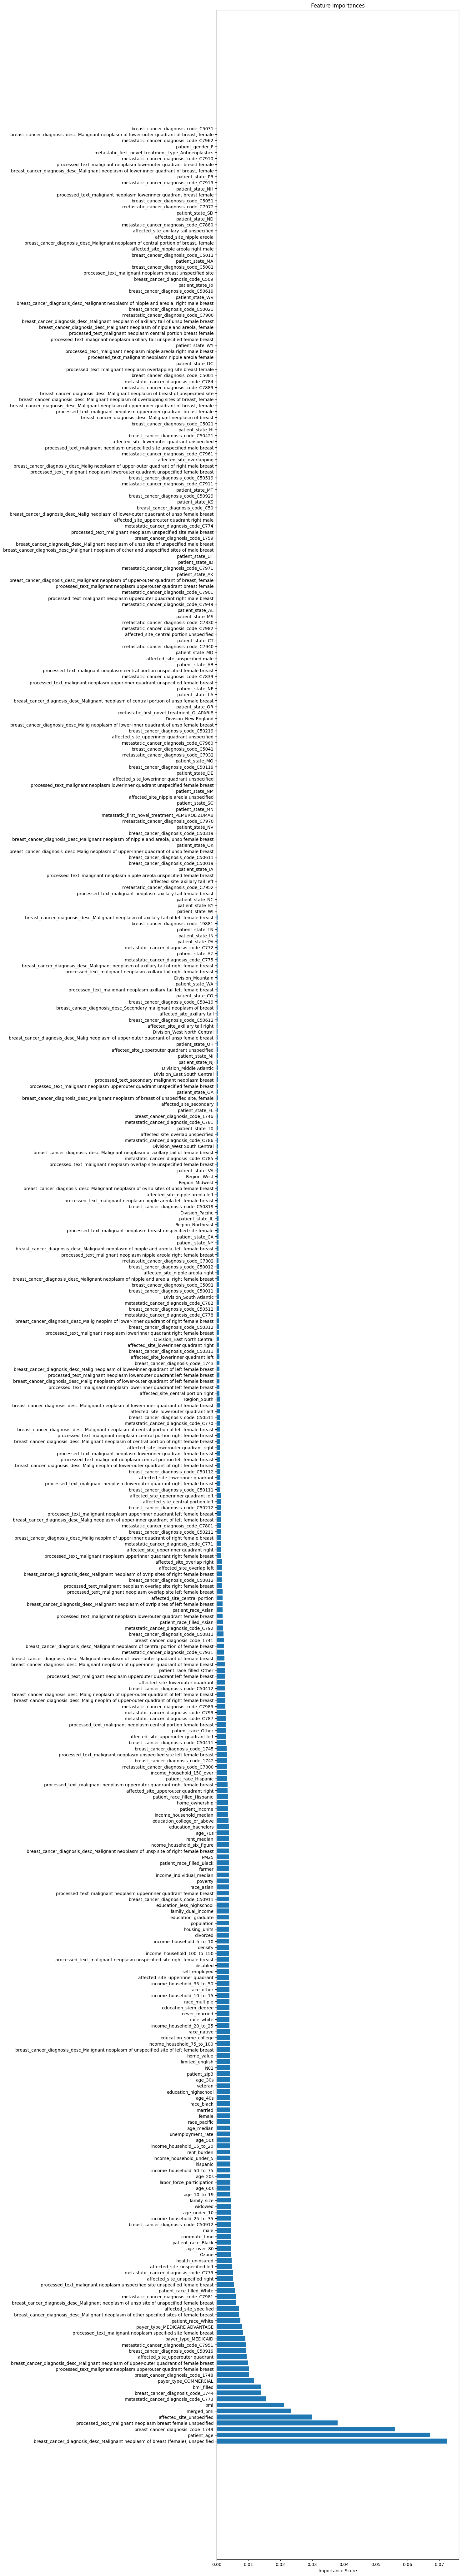

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import pandas as pd
import matplotlib.pyplot as plt

# Load your data (replace 'your_dataset.csv' with your actual dataset)
train_data = pd.read_csv("training_Preprocessed.csv")

# Drop the patient_id column
train_data.drop(columns=['patient_id'], inplace=True)

# Separate features (X) and target variable (y)
X = train_data.drop(columns=["DiagPeriodL90D"])
y = train_data["DiagPeriodL90D"]

# Handle missing values
numerical_features = X.select_dtypes(include=['float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Impute missing values for numerical features
numerical_imputer = SimpleImputer(strategy='mean')
X[numerical_features] = numerical_imputer.fit_transform(X[numerical_features])

# Impute missing values for categorical features
categorical_imputer = SimpleImputer(strategy='most_frequent')
X[categorical_features] = categorical_imputer.fit_transform(X[categorical_features])

# One-hot encode categorical variables
X = pd.get_dummies(X, columns=categorical_features)

# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model to the training data
rf_classifier.fit(X_train, y_train)

# Get feature importances
feature_importances = rf_classifier.feature_importances_

# Get the names of features
feature_names = X_train.columns

# Create a DataFrame with feature names and their importance scores
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 106))  # Adjust figure size as needed
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance Score')
plt.title('Feature Importances')
plt.show()

In [ ]:
# prompt: list the columns of dataset

print(X_train.columns.to_list())


['patient_zip3', 'patient_age', 'bmi', 'population', 'density', 'age_median', 'age_under_10', 'age_10_to_19', 'age_20s', 'age_30s', 'age_40s', 'age_50s', 'age_60s', 'age_70s', 'age_over_80', 'male', 'female', 'married', 'divorced', 'never_married', 'widowed', 'family_size', 'family_dual_income', 'income_household_median', 'income_household_under_5', 'income_household_5_to_10', 'income_household_10_to_15', 'income_household_15_to_20', 'income_household_20_to_25', 'income_household_25_to_35', 'income_household_35_to_50', 'income_household_50_to_75', 'income_household_75_to_100', 'income_household_100_to_150', 'income_household_150_over', 'income_household_six_figure', 'income_individual_median', 'home_ownership', 'housing_units', 'home_value', 'rent_median', 'rent_burden', 'education_less_highschool', 'education_highschool', 'education_some_college', 'education_bachelors', 'education_graduate', 'education_college_or_above', 'education_stem_degree', 'labor_force_participation', 'unemploym

In [ ]:
# Assuming 'train_data' is your DataFrame
null_values = train_data.isnull().sum()
print("Null values in each column:")
print(null_values)


Null values in each column:
patient_race           6385
payer_type             1803
patient_state            51
patient_zip3              0
patient_age               0
                       ... 
merged_bmi                0
processed_text            1
affected_site             1
patient_race_filled       0
patient_income            0
Length: 88, dtype: int64


LASSO Regression:

L1 regularization (LASSO) can be used to encourage sparsity in feature weights, effectively performing feature selection.


In [ ]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Load your data (replace 'your_dataset.csv' with your actual dataset)
train_data = pd.read_csv("cleaned_dataset_encoded.csv")

# Drop the patient_id column
train_data = train_data.drop(['patient_id'], axis=1)

# Handle missing values
# Separate numerical and categorical features
numerical_features = train_data.select_dtypes(include=['float64']).columns
categorical_features = train_data.select_dtypes(include=['object']).columns

# Impute missing values for numerical features
numerical_imputer = SimpleImputer(strategy='mean')
train_data[numerical_features] = numerical_imputer.fit_transform(train_data[numerical_features])

# Impute missing values for categorical features
categorical_imputer = SimpleImputer(strategy='most_frequent')
train_data[categorical_features] = categorical_imputer.fit_transform(train_data[categorical_features])

# One-hot encode categorical variables
train_data = pd.get_dummies(train_data, columns=categorical_features)

# Split the data into features (X) and target variable (y)
X = train_data.drop(columns=["DiagPeriodL90D"])
y = train_data["DiagPeriodL90D"]

# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features (important for regularization)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

# Create the Lasso model
lasso = Lasso(alpha=0.04)  # Adjust the alpha parameter based on the desired level of regularization

# Fit the model to the training data
lasso.fit(X_train_scaled, y_train)

# Get the coefficients of the features
feature_coefficients = pd.Series(lasso.coef_, index=X.columns)

# Get the names of non-zero coefficient features (selected features)
selected_feature_names = feature_coefficients[feature_coefficients != 0].index

# Print the names of selected features
print("Selected Features:")
print(selected_feature_names)


Selected Features:
Index(['breast_cancer_diagnosis_code_1741',
       'breast_cancer_diagnosis_code_1742',
       'breast_cancer_diagnosis_code_1744',
       'breast_cancer_diagnosis_code_1745',
       'breast_cancer_diagnosis_code_1748',
       'breast_cancer_diagnosis_code_1749'],
      dtype='object')


In [ ]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import pandas as pd

# Load your data (replace 'your_dataset.csv' with your actual dataset)
train_data = pd.read_csv("final_rounded.csv")
# train_data_rounded = train_data.round(2)

# Split the data into features (X) and target variable (y)
X = train_data.drop(columns=["DiagPeriodL90D"])
y = train_data["DiagPeriodL90D"]

# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a base classifier (you can use any other classifier of your choice)
base_classifier = RandomForestClassifier()

# Create the RFE model and select 10 features
n_features_to_select = 10
rfe = RFE(estimator=base_classifier, n_features_to_select=n_features_to_select)
X_train_rfe = rfe.fit_transform(X_train, y_train)

# Get the names of the selected features
selected_feature_names = X_train.columns[rfe.support_]

# Create a DataFrame with selected features
selected_features_df = pd.DataFrame(X_train_rfe, columns=selected_feature_names)

# Print the names of selected features
print("Selected Features:")
print(selected_feature_names)


<ipython-input-40-a6bd3aa12be2>:13: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


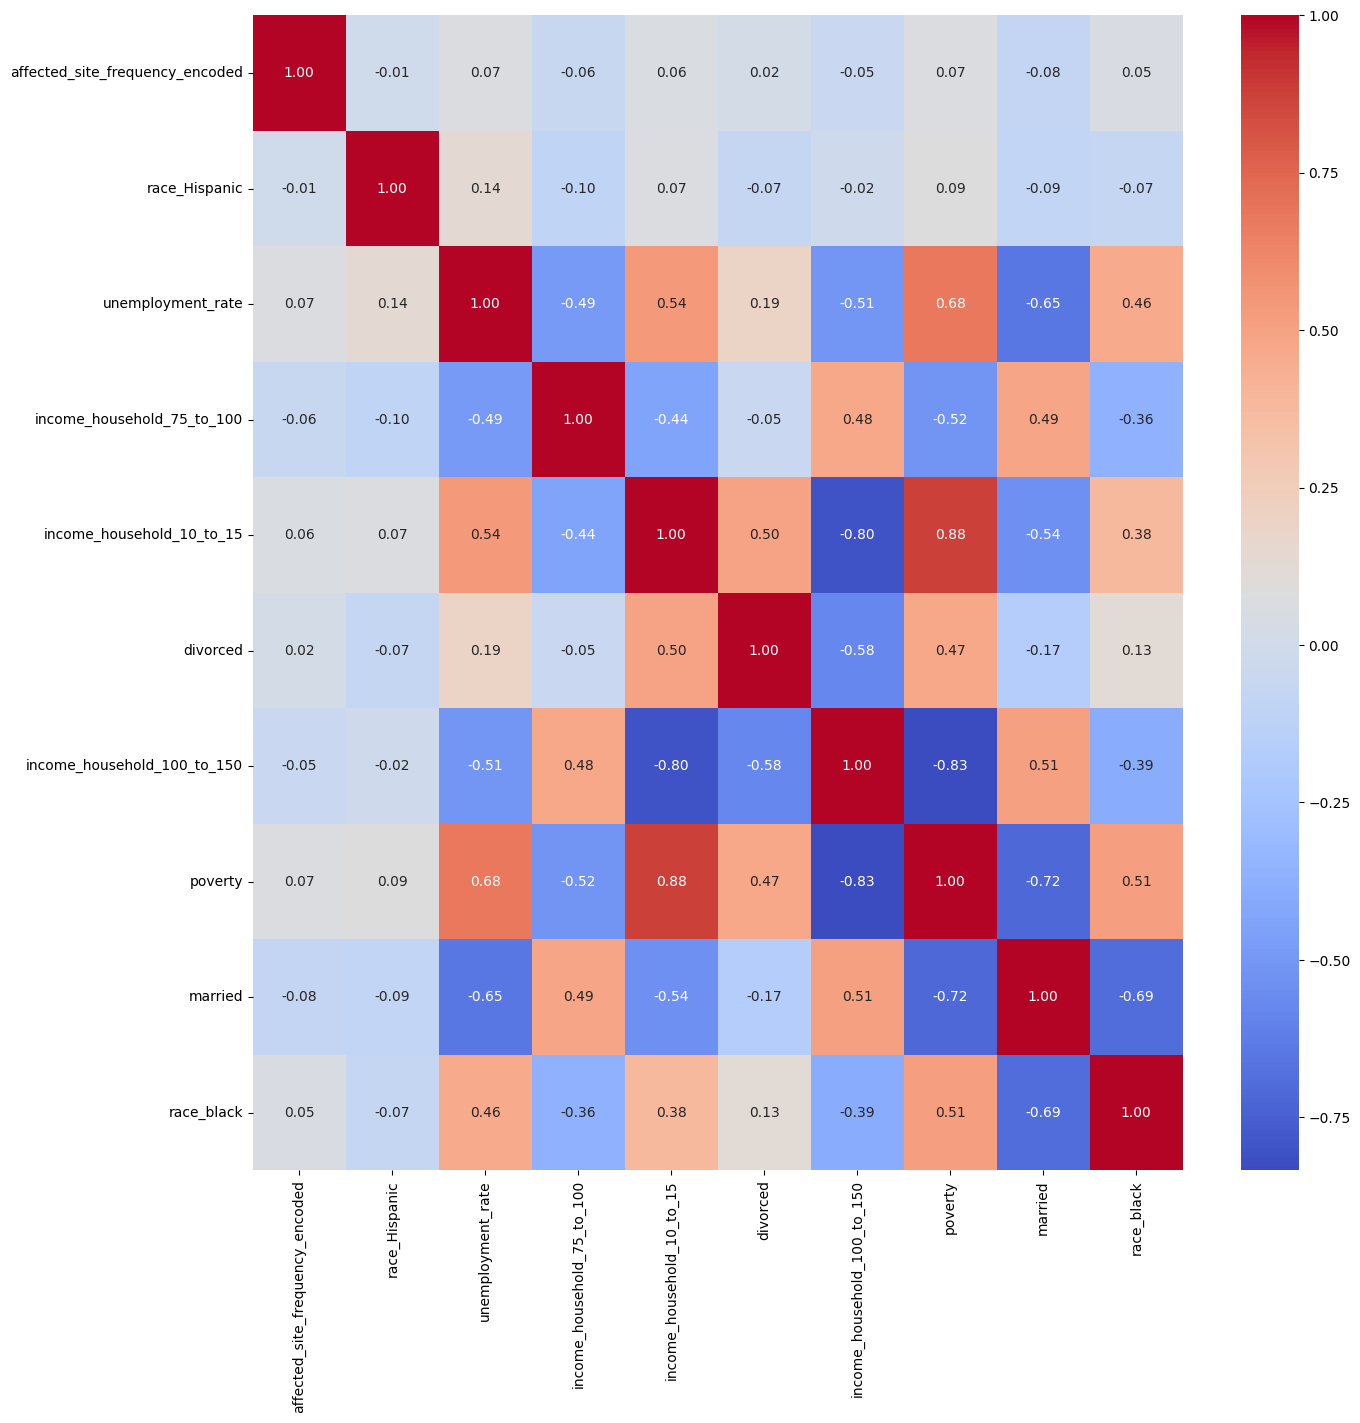

1
Top Col:  Index(['affected_site_frequency_encoded', 'race_Hispanic', 'unemployment_rate',
       'income_household_75_to_100', 'income_household_10_to_15', 'divorced',
       'income_household_100_to_150', 'poverty', 'married', 'race_black'],
      dtype='object')


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd

# Load the Data
df = pd.read_csv('cleaned_dataset_encoded.csv')

correlation_matrix = df.corr()

# Get the top 10 columns with the highest absolute correlation with 'bmi'
top_columns = correlation_matrix['DiagPeriodL90D'].abs().sort_values(ascending=False).head(11).index[1:]

# Plot the heatmap for the top 10 columns
plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix[top_columns].loc[top_columns], annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

print(df['DiagPeriodL90D'].isnull().sum())

print("Top Col: ", top_columns)



Model Building


XGBOOST

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import pandas as pd

# Load the data
df = pd.read_csv('train_final1.csv')

# Split the data into features (X) and target variable (y)
X = df.drop(['DiagPeriodL90D'], axis=1)
y = df['DiagPeriodL90D']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a decision tree model
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

# Generate predictions from the decision tree model
dt_predictions = dt_model.predict(X_test)

# Train an XGBoost model
xgb_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    learning_rate=0.1,
    max_depth=3,
    n_estimators=100,
    random_state=42
)
print(f'Number of labels: {len(y_train)}')
print(f'Number of rows in training data: {X_train_stacked.shape[0]}')
xgb_model.fit(X_train, y_train)

# Generate predictions from the XGBoost model
xgb_predictions = xgb_model.predict(X_test)

# Combine predictions (using a simple average)
hybrid_predictions = (dt_predictions + xgb_predictions) / 2

# Convert hybrid predictions to binary (0 or 1)
hybrid_predictions = (hybrid_predictions > 0.5).astype(int)

# Evaluate accuracy of the hybrid model
accuracy = accuracy_score(y_test, hybrid_predictions)
print(f'Hybrid Model Accuracy: {accuracy}')


Number of labels: 10324


NameError: name 'X_train_stacked' is not defined

Decision Tree Classifier

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Assuming X_train, X_test, y_train, y_test are your training and testing sets
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

# Predictions on the test set
dt_predictions = dt_model.predict(X_test)

# Evaluate accuracy
accuracy_dt = accuracy_score(y_test, dt_predictions)
print(f'Decision Tree Accuracy: {accuracy_dt}')


Decision Tree Accuracy: 0.6494965143299768


XGB

In [5]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import numpy as np
# Initialize XGBoost classifier with specified parameters
xgb_model = XGBClassifier(
    random_state=42,
    booster='gbtree',
    n_estimators=18,
    max_depth=3,
    learning_rate=0.2,
    reg_alpha=0,
    reg_lambda=1,
    gamma=0,
    min_child_weight=1,
    subsample=1,
    colsample_bytree=1,
    missing=np.nan
)

# Fit the model to the training data
xgb_model.fit(X_train, y_train)

# Generate predictions on the test set
xgb_predictions = xgb_model.predict(X_test)

# Evaluate accuracy
accuracy_xgb = accuracy_score(y_test, xgb_predictions)
print(f'XGBoost Accuracy: {accuracy_xgb}')


XGBoost Accuracy: 0.7587141750580945


In [6]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

# Initialize Gradient Boosting classifier with specified parameters
gb_model = GradientBoostingClassifier(
    random_state=42,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    min_samples_leaf=1
)

# Fit the model to the training data
gb_model.fit(X_train, y_train)

# Generate predictions on the test set
gb_predictions = gb_model.predict(X_test)

# Evaluate accuracy
accuracy_gb = accuracy_score(y_test, gb_predictions)
print(f'Gradient Boosting Accuracy: {accuracy_gb}')


Gradient Boosting Accuracy: 0.7575522850503486


LGBM

In [7]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score

import re

# Remove special characters from feature names
X_train.columns = [re.sub(r'[^\w\s]', '', col) for col in X_train.columns]

# Initialize LightGBM classifier with specified parameters
lgbm_model = LGBMClassifier(
    random_state=42,
    n_estimators=9,
    max_leaves=31,
    learning_rate=0.2,
    reg_alpha=0,
    reg_lambda=0,
    min_split_gain=0,
    min_child_weight=0.001,
    subsample=1,
    colsample_bytree=0.7
)

# Fit the model to the training data
lgbm_model.fit(X_train, y_train)

# Generate predictions on the test set
lgbm_predictions = lgbm_model.predict(X_test)

# Evaluate accuracy
accuracy_lgbm = accuracy_score(y_test, lgbm_predictions)
print(f'LightGBM Accuracy: {accuracy_lgbm}')



[LightGBM] [Warning] num_leaves is set=31, max_leaves=31 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] num_leaves is set=31, max_leaves=31 will be ignored. Current value: num_leaves=31
[LightGBM] [Info] Number of positive: 6443, number of negative: 3881
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006324 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17104
[LightGBM] [Info] Number of data points in the train set: 10324, number of used features: 82
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.624080 -> initscore=0.506901
[LightGBM] [Info] Start training from score 0.506901
[LightGBM] [Warning] num_leaves is set=31, max_leaves=31 will be ignored. Current value: num_leaves=31
LightGBM Accuracy: 0.7552285050348567


Model Evaluation

In [16]:
import pandas as pd
import re

# Load the test data
test_data = pd.read_csv('test_final1.csv')

# Clean feature names in test data (if needed)
test_data.columns = [re.sub(r'[^\w\s]', '', col) for col in test_data.columns]

# probability predictions for the test data using the trained LightGBM model
test_prob_predictions = lgbm_model.predict_proba(test_data)[:, 1]

# Round off the probabilities to 1 decimal place
rounded_prob_predictions = [round(prob, 1) for prob in test_prob_predictions]

#  create a DataFrame for submission
submission_df = pd.DataFrame({
    'patient_id': test_data['patient_id'],  # Assuming 'patient_id' is the column name for patient IDs
    'DiagPeriodL90D': rounded_prob_predictions  # Rounded probability predictions for the positive class
})

# Write the submission DataFrame to a CSV file
submission_df.to_csv('submission_probabilities_rounded_LGBM.csv', index=False)

# Download the submission file
from google.colab import files
files.download('submission_probabilities_rounded_LGBM.csv')


[LightGBM] [Warning] num_leaves is set=31, max_leaves=31 will be ignored. Current value: num_leaves=31


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [19]:
import pandas as pd
from xgboost import XGBClassifier
import numpy as np

# Load the test data
test_data = pd.read_csv('test_final1.csv')

# Clean feature names in test data (if needed)
test_data.columns = [re.sub(r'[^\w\s]', '', col) for col in test_data.columns]

# Assuming 'X_test' contains the features for the test data

# Generate probability predictions for the test data using the trained XGBoost model
test_prob_predictions = xgb_model.predict_proba(test_data)[:, 1]  # Assuming you want probabilities for the positive class

# Round off the probabilities to 1 decimal place
rounded_prob_predictions = [round(prob, 1) for prob in test_prob_predictions]

# Assuming 'patient_id' column is present in the test data
patient_ids = test_data['patient_id']

# Ensure that the number of patient IDs matches the number of probability predictions
assert len(patient_ids) == len(rounded_prob_predictions), "Number of patient IDs does not match number of probability predictions"

# Create a DataFrame for submission
submission_df = pd.DataFrame({
    'patient_id': patient_ids,  # Assuming 'patient_id' is the column name for patient IDs
    'DiagPeriodL90D': rounded_prob_predictions  # Rounded probability predictions for the positive class
})

# Write the submission DataFrame to a CSV file
submission_df.to_csv('submission_probabilities_rounded_XGB.csv', index=False)

# Download the submission file
from google.colab import files
files.download('submission_probabilities_rounded_XGB.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

HyperParameter Tunning